In [1]:
from google.cloud import bigquery
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.optimizers import Adam

from transformers import AutoTokenizer
from transformers import DistilBertForTokenClassification
from transformers import Trainer, TrainingArguments

import matplotlib.pyplot as plt
import seaborn as sns

# Reading data

In [17]:
kaggle_balance_transactions = pd.read_csv('./data/Kaggle/kaggle_eth_addresses.csv')

kaggle_balance_transactions.head(5)

,Address,Name,Account Type,Contract Type,Entity,Label,Tags,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7,Akropolis (AKRO),Smart Contract,Token,DeFi,Legit,DeFi,Token Contract,NaN,NaN,NaN,NaN
1,0x1c74cff0376fb4031cd7492cd6db2d66c3f2c6b9,bZx Protocol Token (BZRX),Smart Contract,Token,DeFi,Legit,Token Contract,bZx,DeFi,0x Ecosystem,Trading,Liquidity
2,0x06af07097c9eeb7fd685c692751d5c66db49c215,Chai (CHAI),Smart Contract,Token,DeFi,Legit,DeFi,Token Contract,Verified Contract,NaN,NaN,NaN
3,0xc00e94cb662c3520282e6f5717214004a7f26888,Compound (COMP),Smart Contract,Token,DeFi,Legit,DAO,Compound,Token Contract,NaN,NaN,NaN
4,0xb3319f5d18bc0d84dd1b4825dcde5d5f7266d407,Compound 0x (cZRX),Smart Contract,Token,DeFi,Legit,Token Contract,DeFi,Compound,0x Ecosystem,NaN,NaN


In [18]:
kaggle_balance_transactions['Tags'].unique()

array(['DeFi', 'Token Contract', 'DAO', 'Verified Contract',
       'NEST Protocol', 'Maker', 'Ren', 'Synthetix', 'Aave', 'Loans',
       'Zerion', 'Compound', 'Contract Deployer', 'DeFi Saver', 'dYdX',
       'Zapper.Fi', 'Gitcoin Grants', 'Uniswap', 'Kyber', 'mStable',
       'Dex', 'IDEX', 'Wallet App', 'Tags', 'ABCC', 'Exchange', 'Bgogo',
       'Binance', 'Derivatives', 'Fiat Gateway', 'Liqui.io', 'Bitfinex',
       'Bithumb', 'BitMart', 'BitMax.io', 'Bitstamp', 'Bittrex',
       'Cobinhood', 'Cold Wallet', 'Coinhako', 'CoinMetro', 'Coinone',
       'COSS.io', 'CREX24', 'DigiFinex', 'FTX', 'Gate.io', 'GBX',
       'Gemini', 'HitBTC', 'Hotbit', 'Huobi', 'Kraken', 'Kryptono',
       'KuCoin', 'LAToken', 'Liquid', 'OKEx', 'Paribu', 'Poloniex',
       'Remitano', 'ShapeShift', 'Options Trading', 'TAGZ', 'Tidex',
       'TopBTC', 'Trade.io', 'Upbit', 'YUNBI', 'ZB.com', 'ICO Wallets',
       'Bancor', 'Basic Attention Token', 'Etheroll', 'FOAM', 'Metronome',
       'Status', 'Cloud', 'S

In [19]:
kaggle_balance_transactions_addresses = kaggle_balance_transactions['Address']
kaggle_balance_transactions_addresses

0        0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7
1        0x1c74cff0376fb4031cd7492cd6db2d66c3f2c6b9
2        0x06af07097c9eeb7fd685c692751d5c66db49c215
3        0xc00e94cb662c3520282e6f5717214004a7f26888
4        0xb3319f5d18bc0d84dd1b4825dcde5d5f7266d407
                            ...                    
19133    0xefa1994328e59f8e24d85458810d67a27289679a
19134    0xf6c68965cdc903164284b482ef5dfdb640d9e0de
19135    0xf6e51ae30705cd7248d4d9ac602cb58cc4b61a52
19136    0xfba9a978650672718e86c36018dcf92d85e108cf
19137    0xfd2b3eb22bac1634f8b554a6d67fd11849dc3a0f
Name: Address, Length: 19138, dtype: object

In [5]:
# kaggle_balance_transactions_addresses.to_csv('Kaggle_addresses.csv')

Since the ratio is 97:3, aka around 2500 vs 87 per file, let's take all dodgy label from file 0->9, the new ratio will be 2500:870, aka 7:3, much better?

In [20]:
temp=kaggle_balance_transactions[kaggle_balance_transactions['Label'] == 'Dodgy']
temp

,Address,Name,Account Type,Contract Type,Entity,Label,Tags,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
2153,0xf2effc1cd320ff062bae8649d150dbea3cb6b189,Ethereum (ETH),Smart Contract,Token,NaN,Dodgy,Phish / Hack,NaN,NaN,NaN,NaN,NaN
2505,0x0f598112679b78e17a4a9febc83703710d33489c,Monero Gold (XMRG),Smart Contract,Token,NaN,Dodgy,Unsafe,NaN,NaN,NaN,NaN,NaN
2560,0x226c98fba127213154a121e9ebcfe73236e6f0dd,NKMS (NuCypher),Smart Contract,Token,NaN,Dodgy,Suspicious,NaN,NaN,NaN,NaN,NaN
2608,0xf31b4f7550833a746f788b36f2b292e5fa49a248,Paxos Standard Token (PAX),Smart Contract,Token,NaN,Dodgy,Phishing,Phish / Hack,NaN,NaN,NaN,NaN
2845,0x870cbbd204d5e2317c60374888e4b6be3bfa092b,Tellor (TRB),Smart Contract,Token,NaN,Dodgy,Phish / Hack,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
19132,0xef5da7752c084df1cc719c64bbe06fa98b2c554c,NaN,Smart Contract,NaN,NaN,Dodgy,Parity Bug,NaN,NaN,NaN,NaN,NaN
19133,0xefa1994328e59f8e24d85458810d67a27289679a,NaN,Smart Contract,NaN,NaN,Dodgy,Parity Bug,NaN,NaN,NaN,NaN,NaN
19134,0xf6c68965cdc903164284b482ef5dfdb640d9e0de,NaN,Smart Contract,NaN,NaN,Dodgy,Parity Bug,NaN,NaN,NaN,NaN,NaN
19135,0xf6e51ae30705cd7248d4d9ac602cb58cc4b61a52,NaN,Smart Contract,NaN,NaN,Dodgy,Parity Bug,NaN,NaN,NaN,NaN,NaN


In [21]:
def read_data(filename, x):
    if x != '00':
        target_merged = temp
    else:
        target_merged = kaggle_balance_transactions
    
    frame = pd.read_csv(filename, index_col=None, header=0)
        
    # initialize an empty list to hold the results
    results = []
    chunksize = 100000

    # iterate over the frame data frame in chunks
    for i in tqdm(range(0, len(frame), chunksize)):
        chunk = frame[i:i+chunksize]

        # merge the kaggle_balance_transactions data frame with the current chunk
        merged_df = pd.merge(target_merged, chunk, left_on=['Address'], right_on=['from_address'], how='left', suffixes=('_kbt', '_frame'))
        merged_df = pd.merge(merged_df, chunk, left_on=['Address'], right_on=['to_address'], how='left', suffixes=('_kbt', '_frame'))

        # append the results to the list
        results.append(merged_df)

    # concatenate the results into a single data frame
    merged_df = pd.concat(results)

    # drop duplicates
    merged_df.drop_duplicates(inplace=True)

    # select the columns you want to keep
    columns_to_keep = ['Account Type', 'Label', 'Tags'] + ['value_frame', 'gas_frame', 'block_timestamp_frame',
            'receipt_cumulative_gas_used_frame', #'gas_price_frame',
#            'receipt_gas_used_frame', 'receipt_contract_address_frame',
#            'receipt_root_frame', 'receipt_status_frame', 
#            'block_number_frame', 'block_hash_frame', 'max_fee_per_gas_frame',
#            'max_priority_fee_per_gas_frame', 'transaction_type_frame', 'input_frame',
           'receipt_effective_gas_price_frame', 'address_frame', 'from_address_frame', 'to_address_frame', 
           'eth_balance_frame']

    # create a new data frame with only the columns you want to keep
    new_df = merged_df[columns_to_keep]
    # drop rows where Account Type is NaN
    new_df.dropna(subset=['Account Type'], inplace=True)
    new_df = new_df[new_df['Label'] != 'Label']
    
    return new_df

# Due to Jupyter Notebook mechanism, cannot read 2 files under 1 cell, otherwise memory constraint localy
for x in range(20):
    if x < 10:
        x = '0' + str(x)
        
    fileName = './data/Kaggle/kaggle_10k_balance_transaction_0000000000' + str(x) + '.csv'
    curr_file = read_data(fileName, x)
    curr_file.to_csv('./output/kaggle_10k_balance_transaction_0000000000' + str(x) + '.csv', index=False)
#     new_df = pd.concat(curr_file)
    
# new_df

C:\Users\vieth\AppData\Local\Temp\ipykernel_16752\741275317.py:7: DtypeWarning:

Columns (11,12,22) have mixed types. Specify dtype option on import or set low_memory=False.

100%|██████████| 9/9 [00:07<00:00,  1.18it/s]
C:\Users\vieth\AppData\Local\Temp\ipykernel_16752\741275317.py:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vieth\AppData\Local\Temp\ipykernel_16752\741275317.py:7: DtypeWarning:

Columns (11,12,22) have mixed types. Specify dtype option on import or set low_memory=False.

100%|██████████| 9/9 [00:00<00:00, 31.94it/s]
C:\Users\vieth\AppData\Local\Temp\ipykernel_16752\741275317.py:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\vieth\AppData\Local\Temp\ipykernel_16752\741275317.py:7: DtypeWarning:

Columns (5,11,12,22) have mixed types. Specify dtype option on import or set low_memory=False.

100%|██████████| 9/9 [00:00<00:00, 28.88it/s]
C:\Users\vieth\AppData\Local\Temp\ipykernel_16752\741275317.py:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\vieth\AppData\Local\Temp\ipykernel_16752\741275317.py:7: DtypeWarning:

Columns (5,11,12,22) have mixed types. Specify dtype option on import or set low_memory=False.

100%|██████████| 9/9 [00:00<00:00, 16.88it/s]
C:\Users\vieth\AppData\Local\Temp\ipykernel_16752\741275317.py:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [46]:
new_df = pd.read_csv('./output/kaggle_10k_balance_transaction_000000000000.csv', index_col=None, header=0)
for x in range(1, 20):
    if x < 10:
        x = '0' + str(x)
        
    fileName = './output/kaggle_10k_balance_transaction_0000000000' + str(x) + '.csv'
    df_file = pd.read_csv(fileName, index_col = None, header = 0)
    new_df = pd.concat([new_df, df_file], ignore_index=True)

C:\Users\vieth\AppData\Local\Temp\ipykernel_16752\3911680379.py:1: DtypeWarning:

Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.



In [47]:
new_df.columns

Index(['Account Type', 'Label', 'Tags', 'value_frame', 'gas_frame',
       'block_timestamp_frame', 'receipt_cumulative_gas_used_frame',
       'receipt_effective_gas_price_frame', 'address_frame',
       'from_address_frame', 'to_address_frame', 'eth_balance_frame'],
      dtype='object')

In [48]:
# # df_file2 = read_data(fileName2)
# # new_df = pd.concat([df_file1, df_file2])
# new_df = df_file1
# print (new_df.head(3))
# print('--------------------------------------------------------------------')
print ("Data label distribution check")
labels_dict = dict()
for row in tqdm(new_df.iterrows()):
#     print (row[1]['Label'])
    label_val = row[1]['Label']
    if label_val not in labels_dict.keys():
        labels_dict[label_val] = 1
    else:
        labels_dict[label_val] += 1
        
print (labels_dict)

Data label distribution check


16705138it [07:00, 39734.60it/s]

{'Legit': 16263767, 'Dodgy': 441371}


# Preprocessing Data

In [49]:
# Preprocessing of each columns
for column in new_df.columns:
    if column != 'Label':
        unique_val = new_df[column].unique()
        print ("Column: ", column)

        if new_df[column].dtypes == 'int64':
            new_df[column] = new_df[column].fillna(0)
        else:
            new_df[column] = new_df[column].astype(str)
            new_df[column] = new_df[column].fillna('unknown')
    

#Encode categorical columns:
encoder = LabelEncoder()
encoder_tags = LabelEncoder()
categorical_columns = ['Account Type', 'Tags']
for col in categorical_columns:
    if col == "Tags":
        new_df[col] = encoder_tags.fit_transform(new_df[col])
    else:
        new_df[col] = encoder.fit_transform(new_df[col])

# Target Label column encoder
new_df['encoded_label'] = encoder.fit_transform(new_df['Label'])

new_df

Column:  Account Type
Column:  Tags
Column:  value_frame
Column:  gas_frame
Column:  block_timestamp_frame
Column:  receipt_cumulative_gas_used_frame
Column:  receipt_effective_gas_price_frame
Column:  address_frame
Column:  from_address_frame
Column:  to_address_frame
Column:  eth_balance_frame


,Account Type,Label,Tags,value_frame,gas_frame,block_timestamp_frame,receipt_cumulative_gas_used_frame,receipt_effective_gas_price_frame,address_frame,from_address_frame,to_address_frame,eth_balance_frame,encoded_label
0,0,Legit,77,0,122841.0,2020-08-05 16:42:36 UTC,3159422.0,85600000000.0,0x2b5634c42055806a59e9107ed44d43c426e58258,0x2b5634c42055806a59e9107ed44d43c426e58258,0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7,1481377617827687015,1
1,0,Legit,77,0,156924.0,2020-07-29 00:49:16 UTC,517510.0,65900001751.0,0x2b5634c42055806a59e9107ed44d43c426e58258,0x2b5634c42055806a59e9107ed44d43c426e58258,0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7,1481377617827687015,1
2,0,Legit,77,0,156924.0,2020-08-01 16:52:24 UTC,1602241.0,74000000000.0,0x2b5634c42055806a59e9107ed44d43c426e58258,0x2b5634c42055806a59e9107ed44d43c426e58258,0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7,1481377617827687015,1
3,0,Legit,77,0,156924.0,2020-07-11 23:48:31 UTC,2320739.0,34830000000.0,0x2b5634c42055806a59e9107ed44d43c426e58258,0x2b5634c42055806a59e9107ed44d43c426e58258,0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7,1481377617827687015,1
4,0,Legit,77,0,156870.0,2020-06-06 07:23:44 UTC,261488.0,45100000000.0,0x2b5634c42055806a59e9107ed44d43c426e58258,0x2b5634c42055806a59e9107ed44d43c426e58258,0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7,1481377617827687015,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16705133,1,Dodgy,222,994000000000000000,150000.0,2018-05-15 12:03:05 UTC,1828163.0,50000000000.0,0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98,0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98,0x7db9656fc8435f765df5748e32bf329098ffb5fb,9653655328553882532533,0
16705134,1,Dodgy,222,504000000000000000,150000.0,2018-03-21 20:41:36 UTC,6205786.0,50000000000.0,0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98,0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98,0xa3c67d993bf73aa4f17ec03f900c865a4326cd7f,9653655328553882532533,0
16705135,1,Dodgy,222,3000000000000000000,150000.0,2018-04-02 23:52:17 UTC,1544690.0,21000000000.0,0x17897c5c38362d8f620e70fee0adba109af5db2d,0x185d1a476c7a60e906c37c5477a0cca9c4c91933,0x17897c5c38362d8f620e70fee0adba109af5db2d,0,0
16705136,0,Dodgy,201,70000000000000000,300000.0,2018-11-16 12:03:16 UTC,7463680.0,10000000000.0,0xc0b52b76055c392d67392622ae7737cdb6d42133,0x2e2177360e385d0bb2507dd387f2c1fdfd743494,0xc0b52b76055c392d67392622ae7737cdb6d42133,356724166544716,0


In [12]:
# add a new column to calculate transaction amount in USD
eth_usd_price = 1840  # the ETH/USD price at the time of this code
df = new_df

# convert value from wei to ETH
df['value_frame'] = pd.to_numeric(df['value_frame'], errors='coerce') #/ 10**18
df['eth_balance_frame'] = pd.to_numeric(df['eth_balance_frame'], errors='coerce')
# df['USD_value'] = df['value_frame'] * eth_usd_price
df

,Account Type,Label,Tags,value_frame,gas_frame,block_timestamp_frame,receipt_cumulative_gas_used_frame,receipt_effective_gas_price_frame,address_frame,from_address_frame,to_address_frame,eth_balance_frame,encoded_label
0,0,Legit,77,0.000000e+00,122841.0,2020-08-05 16:42:36 UTC,3159422.0,85600000000.0,0x2b5634c42055806a59e9107ed44d43c426e58258,0x2b5634c42055806a59e9107ed44d43c426e58258,0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7,1.481378e+18,1
1,0,Legit,77,0.000000e+00,156924.0,2020-07-29 00:49:16 UTC,517510.0,65900001751.0,0x2b5634c42055806a59e9107ed44d43c426e58258,0x2b5634c42055806a59e9107ed44d43c426e58258,0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7,1.481378e+18,1
2,0,Legit,77,0.000000e+00,156924.0,2020-08-01 16:52:24 UTC,1602241.0,74000000000.0,0x2b5634c42055806a59e9107ed44d43c426e58258,0x2b5634c42055806a59e9107ed44d43c426e58258,0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7,1.481378e+18,1
3,0,Legit,77,0.000000e+00,156924.0,2020-07-11 23:48:31 UTC,2320739.0,34830000000.0,0x2b5634c42055806a59e9107ed44d43c426e58258,0x2b5634c42055806a59e9107ed44d43c426e58258,0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7,1.481378e+18,1
4,0,Legit,77,0.000000e+00,156870.0,2020-06-06 07:23:44 UTC,261488.0,45100000000.0,0x2b5634c42055806a59e9107ed44d43c426e58258,0x2b5634c42055806a59e9107ed44d43c426e58258,0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7,1.481378e+18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16705133,1,Dodgy,222,9.940000e+17,150000.0,2018-05-15 12:03:05 UTC,1828163.0,50000000000.0,0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98,0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98,0x7db9656fc8435f765df5748e32bf329098ffb5fb,9.653655e+21,0
16705134,1,Dodgy,222,5.040000e+17,150000.0,2018-03-21 20:41:36 UTC,6205786.0,50000000000.0,0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98,0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98,0xa3c67d993bf73aa4f17ec03f900c865a4326cd7f,9.653655e+21,0
16705135,1,Dodgy,222,3.000000e+18,150000.0,2018-04-02 23:52:17 UTC,1544690.0,21000000000.0,0x17897c5c38362d8f620e70fee0adba109af5db2d,0x185d1a476c7a60e906c37c5477a0cca9c4c91933,0x17897c5c38362d8f620e70fee0adba109af5db2d,0.000000e+00,0
16705136,0,Dodgy,201,7.000000e+16,300000.0,2018-11-16 12:03:16 UTC,7463680.0,10000000000.0,0xc0b52b76055c392d67392622ae7737cdb6d42133,0x2e2177360e385d0bb2507dd387f2c1fdfd743494,0xc0b52b76055c392d67392622ae7737cdb6d42133,3.567242e+14,0


In [13]:
df['received_value'] = df.apply(lambda row: row['value_frame'] if row['to_address_frame'] == row['address_frame'] else 0, axis=1)
df['sent_value'] = df.apply(lambda row: row['value_frame'] if row['from_address_frame'] == row['address_frame'] else 0, axis=1)

# calculate number of withdrawals and deposits
df['num_withdrawals'] = df.apply(lambda row: 1 if row['from_address_frame'] == row['address_frame'] else 0, axis=1)
df['num_deposits'] = df.apply(lambda row: 1 if row['to_address_frame'] == row['address_frame'] else 0, axis=1)

df

,Account Type,Label,Tags,value_frame,gas_frame,block_timestamp_frame,receipt_cumulative_gas_used_frame,receipt_effective_gas_price_frame,address_frame,from_address_frame,to_address_frame,eth_balance_frame,encoded_label,received_value,sent_value,num_withdrawals,num_deposits
0,0,Legit,77,0.000000e+00,122841.0,2020-08-05 16:42:36 UTC,3159422.0,85600000000.0,0x2b5634c42055806a59e9107ed44d43c426e58258,0x2b5634c42055806a59e9107ed44d43c426e58258,0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7,1.481378e+18,1,0.000000e+00,0.000000e+00,1,0
1,0,Legit,77,0.000000e+00,156924.0,2020-07-29 00:49:16 UTC,517510.0,65900001751.0,0x2b5634c42055806a59e9107ed44d43c426e58258,0x2b5634c42055806a59e9107ed44d43c426e58258,0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7,1.481378e+18,1,0.000000e+00,0.000000e+00,1,0
2,0,Legit,77,0.000000e+00,156924.0,2020-08-01 16:52:24 UTC,1602241.0,74000000000.0,0x2b5634c42055806a59e9107ed44d43c426e58258,0x2b5634c42055806a59e9107ed44d43c426e58258,0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7,1.481378e+18,1,0.000000e+00,0.000000e+00,1,0
3,0,Legit,77,0.000000e+00,156924.0,2020-07-11 23:48:31 UTC,2320739.0,34830000000.0,0x2b5634c42055806a59e9107ed44d43c426e58258,0x2b5634c42055806a59e9107ed44d43c426e58258,0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7,1.481378e+18,1,0.000000e+00,0.000000e+00,1,0
4,0,Legit,77,0.000000e+00,156870.0,2020-06-06 07:23:44 UTC,261488.0,45100000000.0,0x2b5634c42055806a59e9107ed44d43c426e58258,0x2b5634c42055806a59e9107ed44d43c426e58258,0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7,1.481378e+18,1,0.000000e+00,0.000000e+00,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16705133,1,Dodgy,222,9.940000e+17,150000.0,2018-05-15 12:03:05 UTC,1828163.0,50000000000.0,0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98,0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98,0x7db9656fc8435f765df5748e32bf329098ffb5fb,9.653655e+21,0,0.000000e+00,9.940000e+17,1,0
16705134,1,Dodgy,222,5.040000e+17,150000.0,2018-03-21 20:41:36 UTC,6205786.0,50000000000.0,0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98,0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98,0xa3c67d993bf73aa4f17ec03f900c865a4326cd7f,9.653655e+21,0,0.000000e+00,5.040000e+17,1,0
16705135,1,Dodgy,222,3.000000e+18,150000.0,2018-04-02 23:52:17 UTC,1544690.0,21000000000.0,0x17897c5c38362d8f620e70fee0adba109af5db2d,0x185d1a476c7a60e906c37c5477a0cca9c4c91933,0x17897c5c38362d8f620e70fee0adba109af5db2d,0.000000e+00,0,3.000000e+18,0.000000e+00,0,1
16705136,0,Dodgy,201,7.000000e+16,300000.0,2018-11-16 12:03:16 UTC,7463680.0,10000000000.0,0xc0b52b76055c392d67392622ae7737cdb6d42133,0x2e2177360e385d0bb2507dd387f2c1fdfd743494,0xc0b52b76055c392d67392622ae7737cdb6d42133,3.567242e+14,0,7.000000e+16,0.000000e+00,0,1


In [14]:
agg_dict = {
    'block_timestamp_frame': ['min', 'max'], 
    'receipt_effective_gas_price_frame': ['count'],
    'from_address_frame': pd.Series.nunique, 
    'to_address_frame': pd.Series.nunique,
    'eth_balance_frame': ['last'],
    'received_value': ['sum'],
    'sent_value': ['sum'],
    'num_withdrawals': ['sum'],
    'num_deposits': ['sum']
}
grouped = df.groupby('address_frame').agg(agg_dict)

grouped

block_timestamp_frame  \
                                                                min   
address_frame                                                         
0x0000000000004946c0e9f43f4dee607b0ef1fa1c  2020-06-05 01:22:25 UTC   
0x000000000000541e251335090ac5b47176af4f7e  2019-09-16 09:04:59 UTC   
0x0000000000013949f288172bd7e36837bddc7211  2019-01-28 05:37:59 UTC   
0x0000000000075efbee23fe2de1bd0b7690883cc9  2019-05-22 21:52:25 UTC   
0x0000000000085d4780b73119b644ae5ecd22b376  2019-01-04 07:21:44 UTC   
...                                                             ...   
0xff8d1014da6382f4c07461fbd5f3bed733b229f1  2018-01-12 08:07:13 UTC   
0xffa9817f20ab5742ad016e094b42716cdd4fcb90  2020-01-31 03:02:15 UTC   
0xffec0067f5a79cff07527f63d83dd5462ccf8ba4  2018-05-01 14:47:02 UTC   
0xfffab974088bd5bf3d7e6f522e93dd7861264cdb  2019-09-04 06:42:36 UTC   
nan                                                             nan   

                                                                     \
                                                                max   
address_frame                                                         
0x0000000000004946c0e9f43f4dee607b0ef1fa1c  2022-11-07 13:14:47 UTC   
0x000000000000541e251335090ac5b47176af4f7e  2020-12-08 07:37:21 UTC   
0x0000000000013949f288172bd7e36837bddc7211  2020-03-17 02:14:59 UTC   
0x0000000000075efbee23fe2de1bd0b7690883cc9  2023-04-10 11:05:59 UTC   
0x0000000000085d4780b73119b644ae5ecd22b376  2023-04-29 05:54:11 UTC   
...                                                             ...   
0xff8d1014da6382f4c07461fbd5f3bed733b229f1  2018-04-28 14:22:41 UTC   
0xffa9817f20ab5742ad016e094b42716cdd4fcb90  2020-02-27 06:08:25 UTC   
0xffec0067f5a79cff07527f63d83dd5462ccf8ba4  2023-04-26 20:52:35 UTC   
0xfffab974088bd5bf3d7e6f522e93dd7861264cdb  2019-09-04 06:42:36 UTC   
nan                                                             nan   

                                           receipt_effective_gas_price_frame  \
                                                                       count   
address_frame                                                                  
0x0000000000004946c0e9f43f4dee607b0ef1fa1c                               268   
0x000000000000541e251335090ac5b47176af4f7e                                32   
0x0000000000013949f288172bd7e36837bddc7211                                16   
0x0000000000075efbee23fe2de1bd0b7690883cc9                                73   
0x0000000000085d4780b73119b644ae5ecd22b376                              2498   
...                                                                      ...   
0xff8d1014da6382f4c07461fbd5f3bed733b229f1                                 5   
0xffa9817f20ab5742ad016e094b42716cdd4fcb90                                 2   
0xffec0067f5a79cff07527f63d83dd5462ccf8ba4                              2612   
0xfffab974088bd5bf3d7e6f522e93dd7861264cdb                                 1   
nan                                                                   371666   

                                           from_address_frame  \
                                                      nunique   
address_frame                                                   
0x0000000000004946c0e9f43f4dee607b0ef1fa1c                191   
0x000000000000541e251335090ac5b47176af4f7e                  4   
0x0000000000013949f288172bd7e36837bddc7211                  5   
0x0000000000075efbee23fe2de1bd0b7690883cc9                  8   
0x0000000000085d4780b73119b644ae5ecd22b376               1218   
...                                                       ...   
0xff8d1014da6382f4c07461fbd5f3bed733b229f1                  5   
0xffa9817f20ab5742ad016e094b42716cdd4fcb90                  2   
0xffec0067f5a79cff07527f63d83dd5462ccf8ba4                  1   
0xfffab974088bd5bf3d7e6f522e93dd7861264cdb                  1   
nan                                                         1   

                        

!!!!!!!! We have 3202 unique addresses in training data

In [15]:
# flatten the column names after aggregation
grouped.columns = ['_'.join(col).rstrip('_') for col in grouped.columns.values]

grouped

,block_timestamp_frame_min,block_timestamp_frame_max,receipt_effective_gas_price_frame_count,from_address_frame_nunique,to_address_frame_nunique,eth_balance_frame_last,received_value_sum,sent_value_sum,num_withdrawals_sum,num_deposits_sum
address_frame,,,,,,,,,,
0x0000000000004946c0e9f43f4dee607b0ef1fa1c,2020-06-05 01:22:25 UTC,2022-11-07 13:14:47 UTC,268,191,1,0.000000e+00,0.000000e+00,0.0,0,268
0x000000000000541e251335090ac5b47176af4f7e,2019-09-16 09:04:59 UTC,2020-12-08 07:37:21 UTC,32,4,1,1.016206e+19,1.000000e+19,0.0,0,32
0x0000000000013949f288172bd7e36837bddc7211,2019-01-28 05:37:59 UTC,2020-03-17 02:14:59 UTC,16,5,1,0.000000e+00,0.000000e+00,0.0,0,16
0x0000000000075efbee23fe2de1bd0b7690883cc9,2019-05-22 21:52:25 UTC,2023-04-10 11:05:59 UTC,73,8,1,0.000000e+00,0.000000e+00,0.0,0,73
0x0000000000085d4780b73119b644ae5ecd22b376,2019-01-04 07:21:44 UTC,2023-04-29 05:54:11 UTC,2498,1218,1,0.000000e+00,0.000000e+00,0.0,0,2498
...,...,...,...,...,...,...,...,...,...,...
0xff8d1014da6382f4c07461fbd5f3bed733b229f1,2018-01-12 08:07:13 UTC,2018-04-28 14:22:41 UTC,5,5,1,0.000000e+00,0.000000e+00,0.0,0,5
0xffa9817f20ab5742ad016e094b42716cdd4fcb90,2020-01-31 03:02:15 UTC,2020-02-27 06:08:25 UTC,2,2,1,0.000000e+00,0.000000e+00,0.0,0,2
0xffec0067f5a79cff07527f63d83dd5462ccf8ba4,2018-05-01 14:47:02 UTC,2023-04-26 20:52:35 UTC,2612,1,18,2.056215e+20,0.000000e+00,0.0,2612,0


In [16]:
# calculate highest received USD
grouped['highest_transaction_value'] = df.groupby('address_frame')['value_frame'].max()


grouped.describe()

,receipt_effective_gas_price_frame_count,from_address_frame_nunique,to_address_frame_nunique,eth_balance_frame_last,received_value_sum,sent_value_sum,num_withdrawals_sum,num_deposits_sum,highest_transaction_value
count,3.202000e+03,3202.000000,3202.000000,3.201000e+03,3.202000e+03,3.202000e+03,3202.000000,3.202000e+03,3.201000e+03
mean,5.217095e+03,131.995628,1.801999,1.986393e+21,4.087070e+23,8.258232e+23,164.905372,5.189771e+03,5.419609e+20
std,1.159771e+05,2267.698143,9.141029,7.349296e+22,1.223842e+25,4.668274e+25,6631.282907,1.159209e+05,1.548739e+22
min,1.000000e+00,1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000e+00,0.000000e+00
50%,5.000000e+00,3.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,4.000000e+00,0.000000e+00
75%,2.800000e+01,16.000000,1.000000,0.000000e+00,5.000000e+17,0.000000e+00,0.000000,2.700000e+01,5.000000e+17
max,4.736506e+06,88797.000000,201.000000,3.631147e+24,5.336438e+26,2.641600e+27,371666.000000,4.735584e+06,8.000000e+23


In [17]:
from dateutil.parser import parse

# convert block_timestamp to datetime format
grouped.dropna(subset=['block_timestamp_frame_min'], inplace=True)
grouped.dropna(subset=['block_timestamp_frame_max'], inplace=True)
grouped = grouped.reset_index(drop=False)

grouped

,address_frame,block_timestamp_frame_min,block_timestamp_frame_max,receipt_effective_gas_price_frame_count,from_address_frame_nunique,to_address_frame_nunique,eth_balance_frame_last,received_value_sum,sent_value_sum,num_withdrawals_sum,num_deposits_sum,highest_transaction_value
0,0x0000000000004946c0e9f43f4dee607b0ef1fa1c,2020-06-05 01:22:25 UTC,2022-11-07 13:14:47 UTC,268,191,1,0.000000e+00,0.000000e+00,0.0,0,268,0.000000e+00
1,0x000000000000541e251335090ac5b47176af4f7e,2019-09-16 09:04:59 UTC,2020-12-08 07:37:21 UTC,32,4,1,1.016206e+19,1.000000e+19,0.0,0,32,1.000000e+19
2,0x0000000000013949f288172bd7e36837bddc7211,2019-01-28 05:37:59 UTC,2020-03-17 02:14:59 UTC,16,5,1,0.000000e+00,0.000000e+00,0.0,0,16,0.000000e+00
3,0x0000000000075efbee23fe2de1bd0b7690883cc9,2019-05-22 21:52:25 UTC,2023-04-10 11:05:59 UTC,73,8,1,0.000000e+00,0.000000e+00,0.0,0,73,0.000000e+00
4,0x0000000000085d4780b73119b644ae5ecd22b376,2019-01-04 07:21:44 UTC,2023-04-29 05:54:11 UTC,2498,1218,1,0.000000e+00,0.000000e+00,0.0,0,2498,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...
3197,0xff8d1014da6382f4c07461fbd5f3bed733b229f1,2018-01-12 08:07:13 UTC,2018-04-28 14:22:41 UTC,5,5,1,0.000000e+00,0.000000e+00,0.0,0,5,0.000000e+00
3198,0xffa9817f20ab5742ad016e094b42716cdd4fcb90,2020-01-31 03:02:15 UTC,2020-02-27 06:08:25 UTC,2,2,1,0.000000e+00,0.000000e+00,0.0,0,2,0.000000e+00
3199,0xffec0067f5a79cff07527f63d83dd5462ccf8ba4,2018-05-01 14:47:02 UTC,2023-04-26 20:52:35 UTC,2612,1,18,2.056215e+20,0.000000e+00,0.0,2612,0,0.000000e+00
3200,0xfffab974088bd5bf3d7e6f522e93dd7861264cdb,2019-09-04 06:42:36 UTC,2019-09-04 06:42:36 UTC,1,1,1,5.000000e+14,0.000000e+00,0.0,0,1,0.000000e+00


In [18]:
grouped = grouped.drop(grouped.index[-1])
grouped['block_timestamp_frame_min'] = grouped['block_timestamp_frame_min'].apply(lambda x: parse(x))
grouped['block_timestamp_frame_max'] = grouped['block_timestamp_frame_max'].apply(lambda x: parse(x))

grouped

,address_frame,block_timestamp_frame_min,block_timestamp_frame_max,receipt_effective_gas_price_frame_count,from_address_frame_nunique,to_address_frame_nunique,eth_balance_frame_last,received_value_sum,sent_value_sum,num_withdrawals_sum,num_deposits_sum,highest_transaction_value
0,0x0000000000004946c0e9f43f4dee607b0ef1fa1c,2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+00:00,268,191,1,0.000000e+00,0.000000e+00,0.0,0,268,0.000000e+00
1,0x000000000000541e251335090ac5b47176af4f7e,2019-09-16 09:04:59+00:00,2020-12-08 07:37:21+00:00,32,4,1,1.016206e+19,1.000000e+19,0.0,0,32,1.000000e+19
2,0x0000000000013949f288172bd7e36837bddc7211,2019-01-28 05:37:59+00:00,2020-03-17 02:14:59+00:00,16,5,1,0.000000e+00,0.000000e+00,0.0,0,16,0.000000e+00
3,0x0000000000075efbee23fe2de1bd0b7690883cc9,2019-05-22 21:52:25+00:00,2023-04-10 11:05:59+00:00,73,8,1,0.000000e+00,0.000000e+00,0.0,0,73,0.000000e+00
4,0x0000000000085d4780b73119b644ae5ecd22b376,2019-01-04 07:21:44+00:00,2023-04-29 05:54:11+00:00,2498,1218,1,0.000000e+00,0.000000e+00,0.0,0,2498,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...
3196,0xff759254e578bc7f725428cecb612a502e604f42,2020-05-02 15:46:58+00:00,2020-05-03 04:25:21+00:00,4,4,1,0.000000e+00,0.000000e+00,0.0,0,4,0.000000e+00
3197,0xff8d1014da6382f4c07461fbd5f3bed733b229f1,2018-01-12 08:07:13+00:00,2018-04-28 14:22:41+00:00,5,5,1,0.000000e+00,0.000000e+00,0.0,0,5,0.000000e+00
3198,0xffa9817f20ab5742ad016e094b42716cdd4fcb90,2020-01-31 03:02:15+00:00,2020-02-27 06:08:25+00:00,2,2,1,0.000000e+00,0.000000e+00,0.0,0,2,0.000000e+00
3199,0xffec0067f5a79cff07527f63d83dd5462ccf8ba4,2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+00:00,2612,1,18,2.056215e+20,0.000000e+00,0.0,2612,0,0.000000e+00


In [19]:
# calculate mean time between transactions
grouped['mean_time_between_transactions'] = (
    grouped['block_timestamp_frame_max'] - grouped['block_timestamp_frame_min']) / grouped['receipt_effective_gas_price_frame_count']
grouped['mean_time_between_transactions'] = grouped['mean_time_between_transactions'].apply(lambda x: x.total_seconds())

# calculate lifetime of each address
grouped['lifetime'] = (grouped['block_timestamp_frame_max'] - grouped['block_timestamp_frame_min']).apply(lambda x: x.total_seconds())

grouped

,address_frame,block_timestamp_frame_min,block_timestamp_frame_max,receipt_effective_gas_price_frame_count,from_address_frame_nunique,to_address_frame_nunique,eth_balance_frame_last,received_value_sum,sent_value_sum,num_withdrawals_sum,num_deposits_sum,highest_transaction_value,mean_time_between_transactions,lifetime
0,0x0000000000004946c0e9f43f4dee607b0ef1fa1c,2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+00:00,268,191,1,0.000000e+00,0.000000e+00,0.0,0,268,0.000000e+00,2.854729e+05,76506742.0
1,0x000000000000541e251335090ac5b47176af4f7e,2019-09-16 09:04:59+00:00,2020-12-08 07:37:21+00:00,32,4,1,1.016206e+19,1.000000e+19,0.0,0,32,1.000000e+19,1.212136e+06,38788342.0
2,0x0000000000013949f288172bd7e36837bddc7211,2019-01-28 05:37:59+00:00,2020-03-17 02:14:59+00:00,16,5,1,0.000000e+00,0.000000e+00,0.0,0,16,0.000000e+00,2.234839e+06,35757420.0
3,0x0000000000075efbee23fe2de1bd0b7690883cc9,2019-05-22 21:52:25+00:00,2023-04-10 11:05:59+00:00,73,8,1,0.000000e+00,0.000000e+00,0.0,0,73,0.000000e+00,1.678943e+06,122562814.0
4,0x0000000000085d4780b73119b644ae5ecd22b376,2019-01-04 07:21:44+00:00,2023-04-29 05:54:11+00:00,2498,1218,1,0.000000e+00,0.000000e+00,0.0,0,2498,0.000000e+00,5.450807e+04,136161147.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3196,0xff759254e578bc7f725428cecb612a502e604f42,2020-05-02 15:46:58+00:00,2020-05-03 04:25:21+00:00,4,4,1,0.000000e+00,0.000000e+00,0.0,0,4,0.000000e+00,1.137575e+04,45503.0
3197,0xff8d1014da6382f4c07461fbd5f3bed733b229f1,2018-01-12 08:07:13+00:00,2018-04-28 14:22:41+00:00,5,5,1,0.000000e+00,0.000000e+00,0.0,0,5,0.000000e+00,1.836186e+06,9180928.0
3198,0xffa9817f20ab5742ad016e094b42716cdd4fcb90,2020-01-31 03:02:15+00:00,2020-02-27 06:08:25+00:00,2,2,1,0.000000e+00,0.000000e+00,0.0,0,2,0.000000e+00,1.171985e+06,2343970.0
3199,0xffec0067f5a79cff07527f63d83dd5462ccf8ba4,2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+00:00,2612,1,18,2.056215e+20,0.000000e+00,0.0,2612,0,0.000000e+00,6.024362e+04,157356333.0


In [20]:
merged_df = grouped.merge(df[['address_frame', 'Account Type', 'Label', 'Tags']], on='address_frame', how='left')
merged_df

,address_frame,block_timestamp_frame_min,block_timestamp_frame_max,receipt_effective_gas_price_frame_count,from_address_frame_nunique,to_address_frame_nunique,eth_balance_frame_last,received_value_sum,sent_value_sum,num_withdrawals_sum,num_deposits_sum,highest_transaction_value,mean_time_between_transactions,lifetime,Account Type,Label,Tags
0,0x0000000000004946c0e9f43f4dee607b0ef1fa1c,2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+00:00,268,191,1,0.000000e+00,0.0,0.0,0,268,0.0,285472.917910,76506742.0,0,Legit,256
1,0x0000000000004946c0e9f43f4dee607b0ef1fa1c,2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+00:00,268,191,1,0.000000e+00,0.0,0.0,0,268,0.0,285472.917910,76506742.0,0,Legit,256
2,0x0000000000004946c0e9f43f4dee607b0ef1fa1c,2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+00:00,268,191,1,0.000000e+00,0.0,0.0,0,268,0.0,285472.917910,76506742.0,0,Legit,256
3,0x0000000000004946c0e9f43f4dee607b0ef1fa1c,2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+00:00,268,191,1,0.000000e+00,0.0,0.0,0,268,0.0,285472.917910,76506742.0,0,Legit,256
4,0x0000000000004946c0e9f43f4dee607b0ef1fa1c,2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+00:00,268,191,1,0.000000e+00,0.0,0.0,0,268,0.0,285472.917910,76506742.0,0,Legit,256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16333467,0xffec0067f5a79cff07527f63d83dd5462ccf8ba4,2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+00:00,2612,1,18,2.056215e+20,0.0,0.0,2612,0,0.0,60243.619065,157356333.0,0,Legit,256
16333468,0xffec0067f5a79cff07527f63d83dd5462ccf8ba4,2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+00:00,2612,1,18,2.056215e+20,0.0,0.0,2612,0,0.0,60243.619065,157356333.0,0,Legit,256
16333469,0xffec0067f5a79cff07527f63d83dd5462ccf8ba4,2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+00:00,2612,1,18,2.056215e+20,0.0,0.0,2612,0,0.0,60243.619065,157356333.0,0,Legit,256
16333470,0xffec0067f5a79cff07527f63d83dd5462ccf8ba4,2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+00:00,2612,1,18,2.056215e+20,0.0,0.0,2612,0,0.0,60243.619065,157356333.0,0,Legit,256


In [21]:
merged_df.to_csv("./output/addresses_transaction_data.csv", index=False)

Feature engineering for Tag

In [22]:
from pandas.tseries.offsets import MonthEnd

In [23]:
# Convert block_timestamp_frame to datetime and calculate the end of month timestamp
df['block_timestamp_frame'] = pd.to_datetime(df['block_timestamp_frame'])
df['EndOfMonth'] = df['block_timestamp_frame'].dt.to_period('M').dt.to_timestamp('M') + MonthEnd(1)

# Group by Tags
grouped = df.groupby('Tags')

C:\Users\vieth\AppData\Local\Temp\ipykernel_7040\2410443003.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['EndOfMonth'] = df['block_timestamp_frame'].dt.to_period('M').dt.to_timestamp('M') + MonthEnd(1)


In [24]:
# For each known tag Cluster:
stats = pd.DataFrame()

# Mean # of transactions
stats['MeanNumTransactions'] = grouped['value_frame'].count()

# Mean balance
stats['MeanBalance'] = grouped['eth_balance_frame'].mean()

# Standard Deviation balance
stats['StdDevBalance'] = grouped['eth_balance_frame'].std()
stats

,MeanNumTransactions,MeanBalance,StdDevBalance
Tags,,,
0,1779,0.000000e+00,0.000000e+00
1,2170,8.611655e+15,1.562308e+17
2,0,NaN,NaN
3,0,NaN,NaN
4,0,NaN,NaN
...,...,...,...
287,0,NaN,NaN
288,28,0.000000e+00,0.000000e+00
289,24,0.000000e+00,0.000000e+00


In [25]:
# Cluster lifetime (average of nodes)
stats['ClusterLifetime'] = grouped['block_timestamp_frame'].apply(lambda x: (x.max() - x.min()).days)
stats

,MeanNumTransactions,MeanBalance,StdDevBalance,ClusterLifetime
Tags,,,,
0,1779,0.000000e+00,0.000000e+00,1101.0
1,2170,8.611655e+15,1.562308e+17,2054.0
2,0,NaN,NaN,NaN
3,0,NaN,NaN,NaN
4,0,NaN,NaN,NaN
...,...,...,...,...
287,0,NaN,NaN,NaN
288,28,0.000000e+00,0.000000e+00,286.0
289,24,0.000000e+00,0.000000e+00,230.0


In [26]:
# Mean activity:
## Number of withdrawals / month
stats['NumWithdrawalsPerMonth'] = grouped.apply(lambda x: x['num_withdrawals'].sum() / len(x['EndOfMonth'].unique()))

## Number of deposits / month
stats['NumDepositsPerMonth'] = grouped.apply(lambda x: x['num_deposits'].sum() / len(x['EndOfMonth'].unique()))

stats

,MeanNumTransactions,MeanBalance,StdDevBalance,ClusterLifetime,NumWithdrawalsPerMonth,NumDepositsPerMonth
Tags,,,,,,
0,1779,0.000000e+00,0.000000e+00,1101.0,0.285714,63.821429
1,2170,8.611655e+15,1.562308e+17,2054.0,0.796610,36.322034
2,0,NaN,NaN,NaN,19.000000,19.000000
3,0,NaN,NaN,NaN,12.000000,12.000000
4,0,NaN,NaN,NaN,1.000000,1.000000
...,...,...,...,...,...,...
287,0,NaN,NaN,NaN,2.000000,2.000000
288,28,0.000000e+00,0.000000e+00,286.0,3.000000,5.800000
289,24,0.000000e+00,0.000000e+00,230.0,0.666667,3.333333


In [27]:
# Mean transaction data/ lifetime:
## Mean of received ETH / cluster lifetime
stats['MeanReceivedETHPerLifetime'] = grouped.apply(lambda x: x['received_value'].sum() / (x['block_timestamp_frame'].max() - x['block_timestamp_frame'].min()).days)

## Mean of sent ETH / cluster lifetime
stats['MeanSentETHPerLifetime'] = grouped.apply(lambda x: x['sent_value'].sum() / (x['block_timestamp_frame'].max() - x['block_timestamp_frame'].min()).days)

## Mean time between transactions
stats['MeanTimeBetweenTransactions'] = grouped['block_timestamp_frame'].apply(lambda x: x.sort_values().diff().mean().total_seconds()/60)
stats

C:\Users\vieth\AppData\Local\Temp\ipykernel_7040\483578478.py:3: RuntimeWarning: invalid value encountered in double_scalars
  stats['MeanReceivedETHPerLifetime'] = grouped.apply(lambda x: x['received_value'].sum() / (x['block_timestamp_frame'].max() - x['block_timestamp_frame'].min()).days)
C:\Users\vieth\AppData\Local\Temp\ipykernel_7040\483578478.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  stats['MeanReceivedETHPerLifetime'] = grouped.apply(lambda x: x['received_value'].sum() / (x['block_timestamp_frame'].max() - x['block_timestamp_frame'].min()).days)
C:\Users\vieth\AppData\Local\Temp\ipykernel_7040\483578478.py:6: RuntimeWarning: invalid value encountered in double_scalars
  stats['MeanSentETHPerLifetime'] = grouped.apply(lambda x: x['sent_value'].sum() / (x['block_timestamp_frame'].max() - x['block_timestamp_frame'].min()).days)


,MeanNumTransactions,MeanBalance,StdDevBalance,ClusterLifetime,NumWithdrawalsPerMonth,NumDepositsPerMonth,MeanReceivedETHPerLifetime,MeanSentETHPerLifetime,MeanTimeBetweenTransactions
Tags,,,,,,,,,
0,1779,0.000000e+00,0.000000e+00,1101.0,0.285714,63.821429,9.351984e+14,0.0,891.816545
1,2170,8.611655e+15,1.562308e+17,2054.0,0.796610,36.322034,0.000000e+00,0.0,1364.090157
2,0,NaN,NaN,NaN,19.000000,19.000000,NaN,NaN,NaN
3,0,NaN,NaN,NaN,12.000000,12.000000,NaN,NaN,NaN
4,0,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
287,0,NaN,NaN,NaN,2.000000,2.000000,NaN,NaN,NaN
288,28,0.000000e+00,0.000000e+00,286.0,3.000000,5.800000,1.373339e+18,0.0,15253.958025
289,24,0.000000e+00,0.000000e+00,230.0,0.666667,3.333333,0.000000e+00,0.0,14419.962319


In [28]:
# Reset the index in stats dataframe
stats_reset = stats.reset_index()

# Merge stats with merged_df
final_df = pd.merge(merged_df, stats_reset, left_on='Tags', right_on='Tags', how='left')
final_df

,address_frame,block_timestamp_frame_min,block_timestamp_frame_max,receipt_effective_gas_price_frame_count,from_address_frame_nunique,to_address_frame_nunique,eth_balance_frame_last,received_value_sum,sent_value_sum,num_withdrawals_sum,...,Tags,MeanNumTransactions,MeanBalance,StdDevBalance,ClusterLifetime,NumWithdrawalsPerMonth,NumDepositsPerMonth,MeanReceivedETHPerLifetime,MeanSentETHPerLifetime,MeanTimeBetweenTransactions
0,0x0000000000004946c0e9f43f4dee607b0ef1fa1c,2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+00:00,268,191,1,0.000000e+00,0.0,0.0,0,...,256,74669,3.912831e+20,7.561651e+21,2427.0,127.829268,818.158537,3.970715e+18,0.000000e+00,46.820613
1,0x0000000000004946c0e9f43f4dee607b0ef1fa1c,2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+00:00,268,191,1,0.000000e+00,0.0,0.0,0,...,256,74669,3.912831e+20,7.561651e+21,2427.0,127.829268,818.158537,3.970715e+18,0.000000e+00,46.820613
2,0x0000000000004946c0e9f43f4dee607b0ef1fa1c,2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+00:00,268,191,1,0.000000e+00,0.0,0.0,0,...,256,74669,3.912831e+20,7.561651e+21,2427.0,127.829268,818.158537,3.970715e+18,0.000000e+00,46.820613
3,0x0000000000004946c0e9f43f4dee607b0ef1fa1c,2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+00:00,268,191,1,0.000000e+00,0.0,0.0,0,...,256,74669,3.912831e+20,7.561651e+21,2427.0,127.829268,818.158537,3.970715e+18,0.000000e+00,46.820613
4,0x0000000000004946c0e9f43f4dee607b0ef1fa1c,2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+00:00,268,191,1,0.000000e+00,0.0,0.0,0,...,256,74669,3.912831e+20,7.561651e+21,2427.0,127.829268,818.158537,3.970715e+18,0.000000e+00,46.820613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16333467,0xffec0067f5a79cff07527f63d83dd5462ccf8ba4,2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+00:00,2612,1,18,2.056215e+20,0.0,0.0,2612,...,256,74669,3.912831e+20,7.561651e+21,2427.0,127.829268,818.158537,3.970715e+18,0.000000e+00,46.820613
16333468,0xffec0067f5a79cff07527f63d83dd5462ccf8ba4,2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+00:00,2612,1,18,2.056215e+20,0.0,0.0,2612,...,256,74669,3.912831e+20,7.561651e+21,2427.0,127.829268,818.158537,3.970715e+18,0.000000e+00,46.820613
16333469,0xffec0067f5a79cff07527f63d83dd5462ccf8ba4,2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+00:00,2612,1,18,2.056215e+20,0.0,0.0,2612,...,256,74669,3.912831e+20,7.561651e+21,2427.0,127.829268,818.158537,3.970715e+18,0.000000e+00,46.820613
16333470,0xffec0067f5a79cff07527f63d83dd5462ccf8ba4,2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+00:00,2612,1,18,2.056215e+20,0.0,0.0,2612,...,256,74669,3.912831e+20,7.561651e+21,2427.0,127.829268,818.158537,3.970715e+18,0.000000e+00,46.820613


In [29]:
final_df.columns

Index(['address_frame', 'block_timestamp_frame_min',
       'block_timestamp_frame_max', 'receipt_effective_gas_price_frame_count',
       'from_address_frame_nunique', 'to_address_frame_nunique',
       'eth_balance_frame_last', 'received_value_sum', 'sent_value_sum',
       'num_withdrawals_sum', 'num_deposits_sum', 'highest_transaction_value',
       'mean_time_between_transactions', 'lifetime', 'Account Type', 'Label',
       'Tags', 'MeanNumTransactions', 'MeanBalance', 'StdDevBalance',
       'ClusterLifetime', 'NumWithdrawalsPerMonth', 'NumDepositsPerMonth',
       'MeanReceivedETHPerLifetime', 'MeanSentETHPerLifetime',
       'MeanTimeBetweenTransactions'],
      dtype='object')

In [30]:
# Select only the specific columns from final_df and add 'tag_' prefix to column names
final_df_selected = final_df[['block_timestamp_frame_min', 'block_timestamp_frame_max', 
                              'receipt_effective_gas_price_frame_count',
       'eth_balance_frame_last', 'received_value_sum', 'sent_value_sum',
       'num_withdrawals_sum', 'num_deposits_sum', 'highest_transaction_value',
       'mean_time_between_transactions', 'lifetime', 'Account Type', 'Label',
       'Tags', 'MeanNumTransactions', 'MeanBalance', 'StdDevBalance',
       'ClusterLifetime', 'NumWithdrawalsPerMonth', 'NumDepositsPerMonth',
       'MeanReceivedETHPerLifetime', 'MeanSentETHPerLifetime',
       'MeanTimeBetweenTransactions']]

final_df_selected

,block_timestamp_frame_min,block_timestamp_frame_max,receipt_effective_gas_price_frame_count,eth_balance_frame_last,received_value_sum,sent_value_sum,num_withdrawals_sum,num_deposits_sum,highest_transaction_value,mean_time_between_transactions,...,Tags,MeanNumTransactions,MeanBalance,StdDevBalance,ClusterLifetime,NumWithdrawalsPerMonth,NumDepositsPerMonth,MeanReceivedETHPerLifetime,MeanSentETHPerLifetime,MeanTimeBetweenTransactions
0,2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+00:00,268,0.000000e+00,0.0,0.0,0,268,0.0,285472.917910,...,256,74669,3.912831e+20,7.561651e+21,2427.0,127.829268,818.158537,3.970715e+18,0.000000e+00,46.820613
1,2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+00:00,268,0.000000e+00,0.0,0.0,0,268,0.0,285472.917910,...,256,74669,3.912831e+20,7.561651e+21,2427.0,127.829268,818.158537,3.970715e+18,0.000000e+00,46.820613
2,2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+00:00,268,0.000000e+00,0.0,0.0,0,268,0.0,285472.917910,...,256,74669,3.912831e+20,7.561651e+21,2427.0,127.829268,818.158537,3.970715e+18,0.000000e+00,46.820613
3,2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+00:00,268,0.000000e+00,0.0,0.0,0,268,0.0,285472.917910,...,256,74669,3.912831e+20,7.561651e+21,2427.0,127.829268,818.158537,3.970715e+18,0.000000e+00,46.820613
4,2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+00:00,268,0.000000e+00,0.0,0.0,0,268,0.0,285472.917910,...,256,74669,3.912831e+20,7.561651e+21,2427.0,127.829268,818.158537,3.970715e+18,0.000000e+00,46.820613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16333467,2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+00:00,2612,2.056215e+20,0.0,0.0,2612,0,0.0,60243.619065,...,256,74669,3.912831e+20,7.561651e+21,2427.0,127.829268,818.158537,3.970715e+18,0.000000e+00,46.820613
16333468,2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+00:00,2612,2.056215e+20,0.0,0.0,2612,0,0.0,60243.619065,...,256,74669,3.912831e+20,7.561651e+21,2427.0,127.829268,818.158537,3.970715e+18,0.000000e+00,46.820613
16333469,2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+00:00,2612,2.056215e+20,0.0,0.0,2612,0,0.0,60243.619065,...,256,74669,3.912831e+20,7.561651e+21,2427.0,127.829268,818.158537,3.970715e+18,0.000000e+00,46.820613
16333470,2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+00:00,2612,2.056215e+20,0.0,0.0,2612,0,0.0,60243.619065,...,256,74669,3.912831e+20,7.561651e+21,2427.0,127.829268,818.158537,3.970715e+18,0.000000e+00,46.820613


In [31]:
final_df_selected.describe()

,receipt_effective_gas_price_frame_count,eth_balance_frame_last,received_value_sum,sent_value_sum,num_withdrawals_sum,num_deposits_sum,highest_transaction_value,mean_time_between_transactions,lifetime,Account Type,Tags,MeanNumTransactions,MeanBalance,StdDevBalance,ClusterLifetime,NumWithdrawalsPerMonth,NumDepositsPerMonth,MeanReceivedETHPerLifetime,MeanSentETHPerLifetime,MeanTimeBetweenTransactions
count,1.633347e+07,1.633347e+07,1.633347e+07,1.633347e+07,1.633347e+07,1.633347e+07,1.633347e+07,1.633347e+07,1.633347e+07,1.633347e+07,1.633347e+07,1.633347e+07,1.633347e+07,1.633346e+07,1.633347e+07,1.633347e+07,1.633347e+07,1.633346e+07,1.633346e+07,1.633346e+07
mean,2.632916e+06,9.795182e+21,7.317796e+25,5.429879e+23,3.620612e+03,2.631598e+06,4.442954e+22,6.068455e+03,1.593428e+08,9.691350e-01,9.710236e+01,3.262886e+06,9.795182e+21,1.719111e+21,2.373710e+03,2.801786e+02,5.009473e+04,inf,1.100974e+21,2.275736e+01
std,1.751975e+06,1.467589e+23,1.076579e+26,3.755531e+25,5.342966e+03,1.751983e+06,6.846340e+22,1.418736e+05,4.886482e+07,1.729519e-01,8.650002e+01,1.648249e+06,1.464802e+23,8.876359e+21,4.059158e+02,4.847691e+02,2.647234e+04,NaN,2.844038e+22,8.556790e+02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.451613e-02,2.857143e-02,0.000000e+00,0.000000e+00,7.412188e-01
25%,9.789470e+05,1.481378e+18,1.492538e+24,1.924563e+18,1.100000e+01,9.788680e+05,9.999395e+19,3.193017e+01,1.512374e+08,1.000000e+00,2.600000e+01,2.065291e+06,3.692507e+18,2.008846e+19,2.443000e+03,1.070941e+02,2.367051e+04,2.308111e+21,3.346783e+18,7.412188e-01
50%,2.593421e+06,3.689065e+18,3.333877e+24,7.988328e+18,1.103000e+03,2.588214e+06,5.655258e+20,9.338725e+01,1.512374e+08,1.000000e+00,1.010000e+02,4.394551e+06,3.692507e+18,1.192409e+20,2.467000e+03,1.310238e+02,5.177567e+04,2.414714e+21,4.680820e+19,8.332201e-01
75%,4.736506e+06,9.653655e+21,2.287634e+26,1.459103e+22,3.202000e+03,4.735584e+06,1.500000e+23,2.015055e+02,1.645783e+08,1.000000e+00,1.010000e+02,4.748026e+06,7.580374e+21,4.110457e+21,2.542000e+03,1.862368e+02,6.233008e+04,9.368319e+22,7.512416e+20,1.805178e+00
max,4.736506e+06,3.631147e+24,5.336438e+26,2.641600e+27,4.116600e+04,4.735584e+06,8.000000e+23,5.196144e+07,2.421924e+08,1.000000e+00,2.890000e+02,4.748026e+06,3.618505e+24,2.132920e+23,2.822000e+03,8.857000e+03,8.988676e+04,inf,9.360737e+23,1.036272e+06


In [34]:
# Replace inf and NaN values with 0 in 'MeanReceivedETHPerLifetime' column
final_df_selected['MeanReceivedETHPerLifetime'] = final_df_selected['MeanReceivedETHPerLifetime'].replace([np.inf, -np.inf], np.nan)
final_df_selected['MeanReceivedETHPerLifetime'].fillna(0, inplace=True)
final_df_selected['MeanSentETHPerLifetime'].fillna(0, inplace=True)
final_df_selected['MeanTimeBetweenTransactions'].fillna(0, inplace=True)
final_df_selected['StdDevBalance'].fillna(0, inplace=True)

# Check if there are any NaN values in the entire dataframe
print(final_df_selected.isnull().any())

C:\Users\vieth\AppData\Local\Temp\ipykernel_7040\1138533592.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_selected['MeanReceivedETHPerLifetime'] = final_df_selected['MeanReceivedETHPerLifetime'].replace([np.inf, -np.inf], np.nan)
C:\Users\vieth\AppData\Local\Temp\ipykernel_7040\1138533592.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_selected['MeanReceivedETHPerLifetime'].fillna(0, inplace=True)
C:\Users\vieth\AppData\Local\Temp\ipykernel_7040\1138533592.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

block_timestamp_frame_min                  False
block_timestamp_frame_max                  False
receipt_effective_gas_price_frame_count    False
eth_balance_frame_last                     False
received_value_sum                         False
sent_value_sum                             False
num_withdrawals_sum                        False
num_deposits_sum                           False
highest_transaction_value                  False
mean_time_between_transactions             False
lifetime                                   False
Account Type                               False
Label                                      False
Tags                                       False
MeanNumTransactions                        False
MeanBalance                                False
StdDevBalance                              False
ClusterLifetime                            False
NumWithdrawalsPerMonth                     False
NumDepositsPerMonth                        False
MeanReceivedETHPerLi

In [35]:
# Memory is full
# Save the transformed DataFrame to a file
import os

# print ('Create text column')
# new_df['text'] = str(new_df['Account Type']) + ' ' + str(new_df['Contract Type']) 
path = "./output/"
isExist = os.path.exists(path)
if isExist == False:
    os.makedirs(path)
    
final_df_selected.to_csv("./output/transformed_data.csv", index=False)

# Clear the memory
del final_df_selected
# Free up memory in cse del new_df not working
import gc

gc.collect()

0

# Legit is 1, Dodgy is 0

In [39]:
# Function to process a single chunk of data
def process_chunk(chunk):
    # Replace "Legit" with 1 and "Dodgy" with 0 in 'Label' column
    chunk['encoded_label'] = chunk['Label'].replace({'Legit': 1, 'Dodgy': 0})
    
    # Get a list of column names to concatenate
    cols_to_concat = [col for col in chunk.columns if col not in ['Label', 'encoded_label']]
    # Concatenate the values in each row of the specified columns, and store the result in a new column called 'concatenated_values'
    chunk['text'] = chunk[cols_to_concat].apply(lambda row: ','.join(str(val) for val in row), axis=1)

    return chunk[['text', 'encoded_label']]

# Read and process the data in chunks
chunksize = 1000000  # Adjust this value based on your available memory
processed_data = []

In [40]:
# Combine relevant columns into a single text column
with pd.read_csv("./output/transformed_data.csv", chunksize=chunksize) as reader:
    i = 0
    for chunk in reader:
        print ("----------------Processing chunk: ", i ,"-----------------------")
        processed_chunk = process_chunk(chunk)
        processed_data.append(processed_chunk)
        i += 1

print ("Finish text column generation, combining chunk....")
# Combine all processed chunks into a single DataFrame
processed_data = pd.concat(processed_data, ignore_index=True)
#     str(new_df['Account Type']) + ' ' + str(new_df['Contract Type']) 
# + ' ' + str(new_df['Entity']) + ' ' + str(new_df['Tags'])+ ' '  +\
#     new_df['value_frame'] + ' ' + new_df['gas_frame'] + ' ' + new_df['gas_price_frame'] + ' ' + new_df['input_frame']+ ' '  +\
#     new_df['receipt_cumulative_gas_used_frame'] + ' ' + new_df['receipt_gas_used_frame'] + new_df['receipt_contract_address_frame']+ ' '  +\
#     new_df['block_timestamp_frame'] + ' ' + new_df['block_number_frame'] + ' ' + new_df['max_fee_per_gas_frame'] + ' ' +\
#     new_df['max_priority_fee_per_gas_frame'] + new_df['transaction_type_frame'] + ' ' + new_df['address_frame']+ ' '  +\
#     new_df['eth_balance_frame'] + ' ' + new_df['receipt_effective_gas_price_frame']

processed_data

----------------Processing chunk:  0 -----------------------
----------------Processing chunk:  1 -----------------------
----------------Processing chunk:  2 -----------------------
----------------Processing chunk:  3 -----------------------
----------------Processing chunk:  4 -----------------------
----------------Processing chunk:  5 -----------------------
----------------Processing chunk:  6 -----------------------
----------------Processing chunk:  7 -----------------------
----------------Processing chunk:  8 -----------------------
----------------Processing chunk:  9 -----------------------
----------------Processing chunk:  10 -----------------------
----------------Processing chunk:  11 -----------------------
----------------Processing chunk:  12 -----------------------
----------------Processing chunk:  13 -----------------------
----------------Processing chunk:  14 -----------------------
----------------Processing chunk:  15 -----------------------
----------------Pr

,text,encoded_label
0,"2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+...",1
1,"2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+...",1
2,"2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+...",1
3,"2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+...",1
4,"2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+...",1
...,...,...
16333467,"2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+...",1
16333468,"2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+...",1
16333469,"2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+...",1
16333470,"2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+...",1


In [41]:
processed_data.to_csv("./output/one_text_col_data.csv", index=False)
del processed_data

Read it back to clear up RAM

# ToDo oversampling to counter the distribution 97 vs 3, even though the ratio reflect real life ratio, according to Chainanalysis 2023 report

In [2]:
print ('Handle features for Oversampling/Undersampling-----------')
processed_data = pd.read_csv('./output/one_text_col_data.csv')
processed_data

Handle features for Oversampling/Undersampling-----------


,text,encoded_label
0,"2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+...",1
1,"2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+...",1
2,"2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+...",1
3,"2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+...",1
4,"2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+...",1
...,...,...
16333467,"2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+...",1
16333468,"2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+...",1
16333469,"2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+...",1
16333470,"2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+...",1


In [ ]:
# # X_train_smote = np.array(X_train['text'].tolist())
# # X_train_smote

# # Convert the list of lists to a 2D NumPy array of float type
# X_train_smote = np.array(X_train['text'].tolist(), dtype=np.float64)
# X_train_smote

In [ ]:
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_smote, y_train)
# y_train_resampled

In [3]:
# Assuming your DataFrame is named 'processed_data'
# Separate the DataFrame into two DataFrames based on the class label
class_0 = processed_data[processed_data['encoded_label'] == 0]
class_1 = processed_data[processed_data['encoded_label'] == 1]

# Calculate the number of samples needed for each class based on the desired ratio (e.g., 50:50)
desired_ratio = 0.5
total_samples = len(processed_data)
num_samples_class_0 = int(total_samples * desired_ratio)
num_samples_class_1 = total_samples - num_samples_class_0

# Perform oversampling for class 0 (minority class)
# Accept duplication because there are too few "dodgy" class
oversampled_class_0 = class_0.sample(n=num_samples_class_0, replace=True, random_state=42)

# Perform undersampling for class 1 (majority class)
undersampled_class_1 = class_1.sample(n=num_samples_class_1, random_state=42)

# Concatenate the resulting DataFrames
balanced_data = pd.concat([oversampled_class_0, undersampled_class_1])

# Shuffle the new balanced DataFrame
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [4]:
print ("Data label distribution check")
labels_dict = dict()
for row in tqdm(balanced_data.iterrows()):
#     print (row[1]['Label'])
    label_val = row[1]['encoded_label']
    if label_val not in labels_dict.keys():
        labels_dict[label_val] = 1
    else:
        labels_dict[label_val] += 1
        
print (labels_dict)

Data label distribution check


16333472it [06:32, 41577.68it/s]

{1: 8166736, 0: 8166736}


In [5]:
balanced_data.to_csv("./output/50_50_balanced_data.csv", index=False)

# ToDo: Data Visualization on dataset. For instance:

1) Time of the day with most transaction
2) Average gas fees for each tag 
3) Average transaction value for label

In [2]:
data = pd.read_csv("./output/transformed_data.csv")
data

,block_timestamp_frame_min,block_timestamp_frame_max,receipt_effective_gas_price_frame_count,eth_balance_frame_last,received_value_sum,sent_value_sum,num_withdrawals_sum,num_deposits_sum,highest_transaction_value,mean_time_between_transactions,...,Tags,MeanNumTransactions,MeanBalance,StdDevBalance,ClusterLifetime,NumWithdrawalsPerMonth,NumDepositsPerMonth,MeanReceivedETHPerLifetime,MeanSentETHPerLifetime,MeanTimeBetweenTransactions
0,2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+00:00,268,0.000000e+00,0.0,0.0,0,268,0.0,285472.917910,...,256,74669,3.912831e+20,7.561651e+21,2427.0,127.829268,818.158537,3.970715e+18,0.000000e+00,46.820613
1,2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+00:00,268,0.000000e+00,0.0,0.0,0,268,0.0,285472.917910,...,256,74669,3.912831e+20,7.561651e+21,2427.0,127.829268,818.158537,3.970715e+18,0.000000e+00,46.820613
2,2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+00:00,268,0.000000e+00,0.0,0.0,0,268,0.0,285472.917910,...,256,74669,3.912831e+20,7.561651e+21,2427.0,127.829268,818.158537,3.970715e+18,0.000000e+00,46.820613
3,2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+00:00,268,0.000000e+00,0.0,0.0,0,268,0.0,285472.917910,...,256,74669,3.912831e+20,7.561651e+21,2427.0,127.829268,818.158537,3.970715e+18,0.000000e+00,46.820613
4,2020-06-05 01:22:25+00:00,2022-11-07 13:14:47+00:00,268,0.000000e+00,0.0,0.0,0,268,0.0,285472.917910,...,256,74669,3.912831e+20,7.561651e+21,2427.0,127.829268,818.158537,3.970715e+18,0.000000e+00,46.820613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16333467,2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+00:00,2612,2.056215e+20,0.0,0.0,2612,0,0.0,60243.619065,...,256,74669,3.912831e+20,7.561651e+21,2427.0,127.829268,818.158537,3.970715e+18,0.000000e+00,46.820613
16333468,2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+00:00,2612,2.056215e+20,0.0,0.0,2612,0,0.0,60243.619065,...,256,74669,3.912831e+20,7.561651e+21,2427.0,127.829268,818.158537,3.970715e+18,0.000000e+00,46.820613
16333469,2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+00:00,2612,2.056215e+20,0.0,0.0,2612,0,0.0,60243.619065,...,256,74669,3.912831e+20,7.561651e+21,2427.0,127.829268,818.158537,3.970715e+18,0.000000e+00,46.820613
16333470,2018-05-01 14:47:02+00:00,2023-04-26 20:52:35+00:00,2612,2.056215e+20,0.0,0.0,2612,0,0.0,60243.619065,...,256,74669,3.912831e+20,7.561651e+21,2427.0,127.829268,818.158537,3.970715e+18,0.000000e+00,46.820613


C:\Users\vieth\AppData\Local\Temp\ipykernel_16752\2945956683.py:9: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



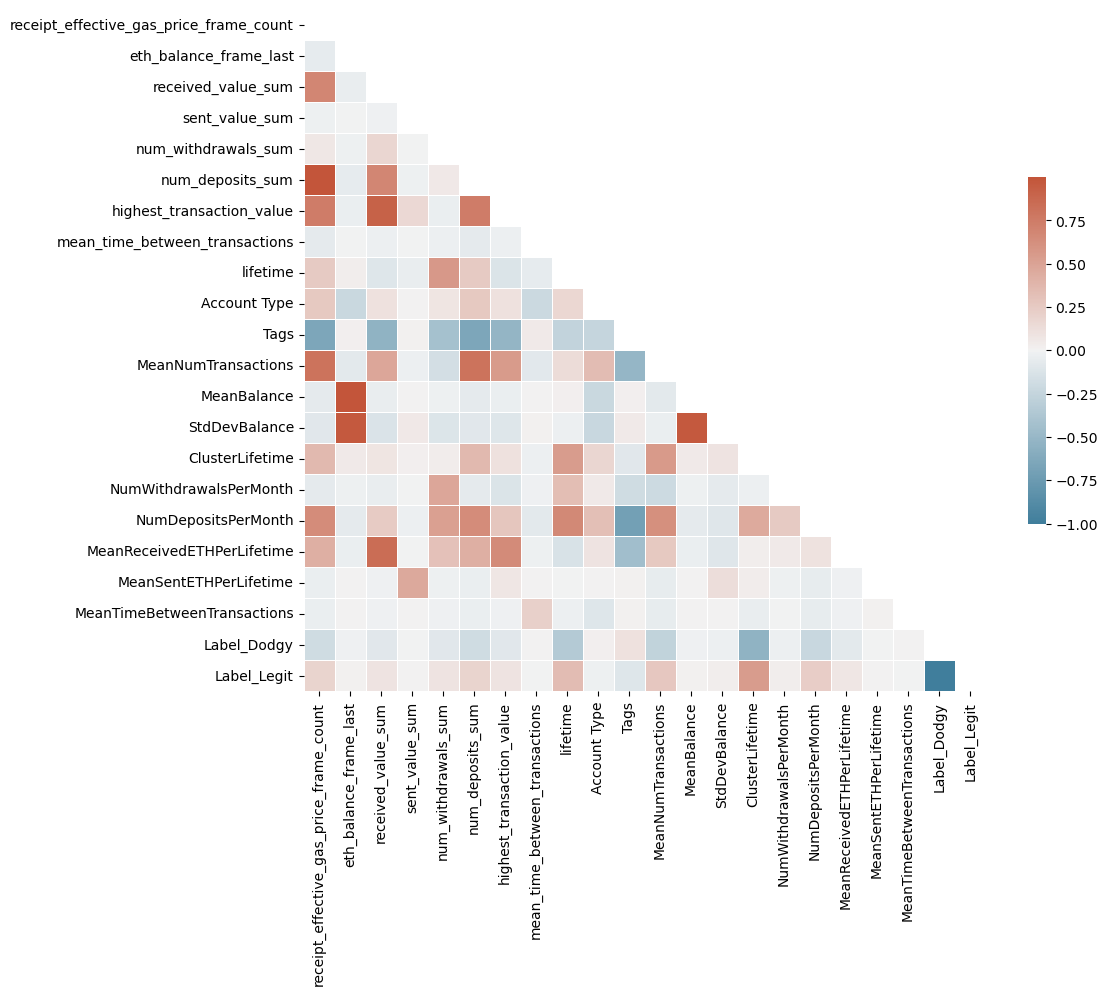

In [13]:
# plt.figure(figsize=(15,15))
# sns.heatmap(data.select_dtypes(include='number').corr(), annot=True, fmt=".2f")
# plt.show()

# One-hot encode the 'Label' column
df_encoded = pd.get_dummies(data, columns=['Label'])

# Calculate correlation matrix
corr = df_encoded.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

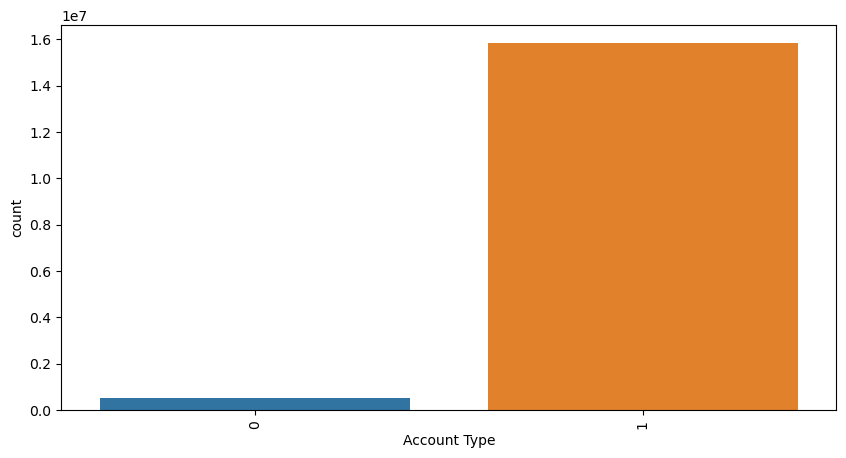

Account Type 1 is Wallet, Type 0 is Smart Contract


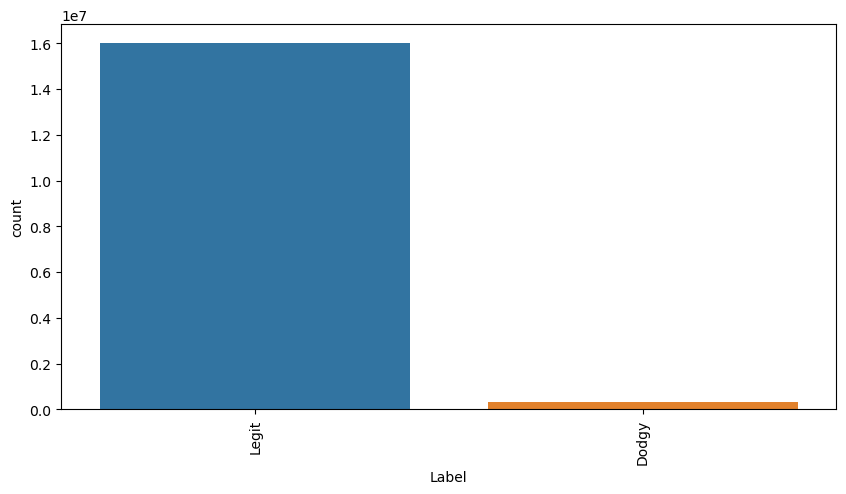

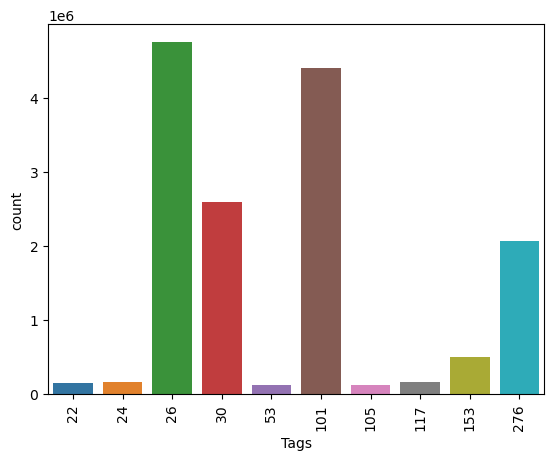

In [60]:
def plot_bar(column):
    plt.figure(figsize=(10,5))
    sns.countplot(data=data, x=column)
    plt.xticks(rotation=90)  # Rotate x-axis labels for readability
    plt.show()

plot_bar('Account Type')
print ("Account Type 1 is Wallet, Type 0 is Smart Contract")
plot_bar('Label')

# Wayyyy to many tags (250+) so we have to settle at most common tags
top_n = 10
top_tags = data['Tags'].value_counts().index[:top_n]
df_top_tags = data[data['Tags'].isin(top_tags)]

sns.countplot(data=df_top_tags, x='Tags')
plt.xticks(rotation=90)
plt.show()

In [57]:
for tag_encoded in top_tags:
    original_tag = encoder_tags.inverse_transform([tag_encoded])
    print("tag_encoded " + str(tag_encoded) + " is " + str(original_tag[0]))

tag_encoded 26 is Bitfinex
tag_encoded 101 is Exchange
tag_encoded 30 is Bittrex
tag_encoded 276 is Wallet App
tag_encoded 153 is KuCoin
tag_encoded 117 is Gambling
tag_encoded 24 is BitMax.io
tag_encoded 22 is Binance
tag_encoded 105 is FTX
tag_encoded 53 is Coinone


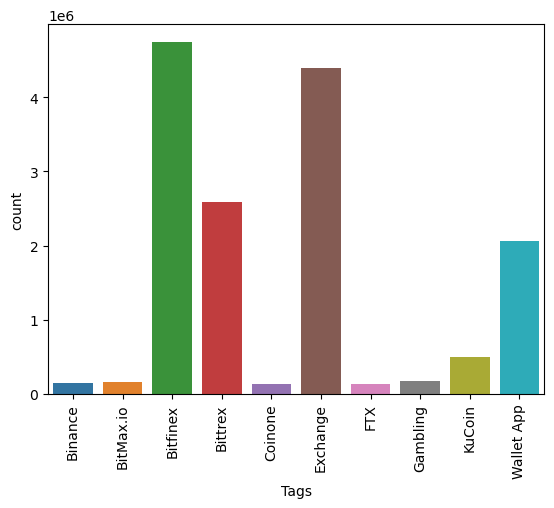

In [59]:
sns.countplot(data=df_top_tags, x='Tags')

# Customize x-axis labels
original_tags = ['Binance', 'BitMax.io', 'Bitfinex', 'Bittrex', 'Coinone', 'Exchange', 'FTX', 'Gambling', 'KuCoin', 'Wallet App']
plt.xticks(rotation='vertical')  # Optional: Rotate labels if they're long
plt.gca().set_xticklabels(original_tags)

plt.show()

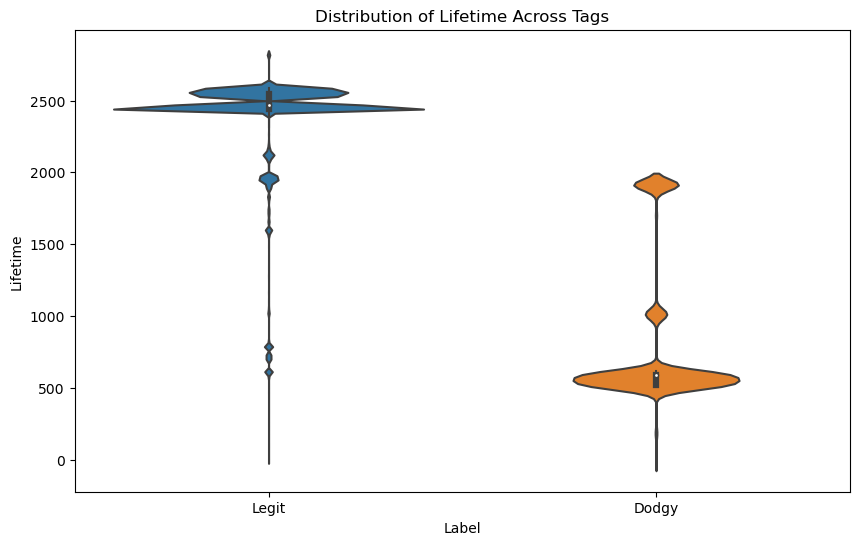

In [14]:
# Assuming Tags column contains "legit" and "dodgy"
plt.figure(figsize=(10, 6))  # You can adjust the size to fit your needs
sns.violinplot(x='Label', y='ClusterLifetime' , data=data)
plt.title('Distribution of Lifetime Across Tags')
plt.xlabel('Label')
plt.ylabel('Lifetime')
plt.show()

# sns.barplot(x='Label', y='ClusterLifetime', data=data, estimator=np.mean)
# plt.title('Average Lifetime for Each Tag')
# plt.xlabel('Label')
# plt.ylabel('Average Lifetime')
# plt.show()

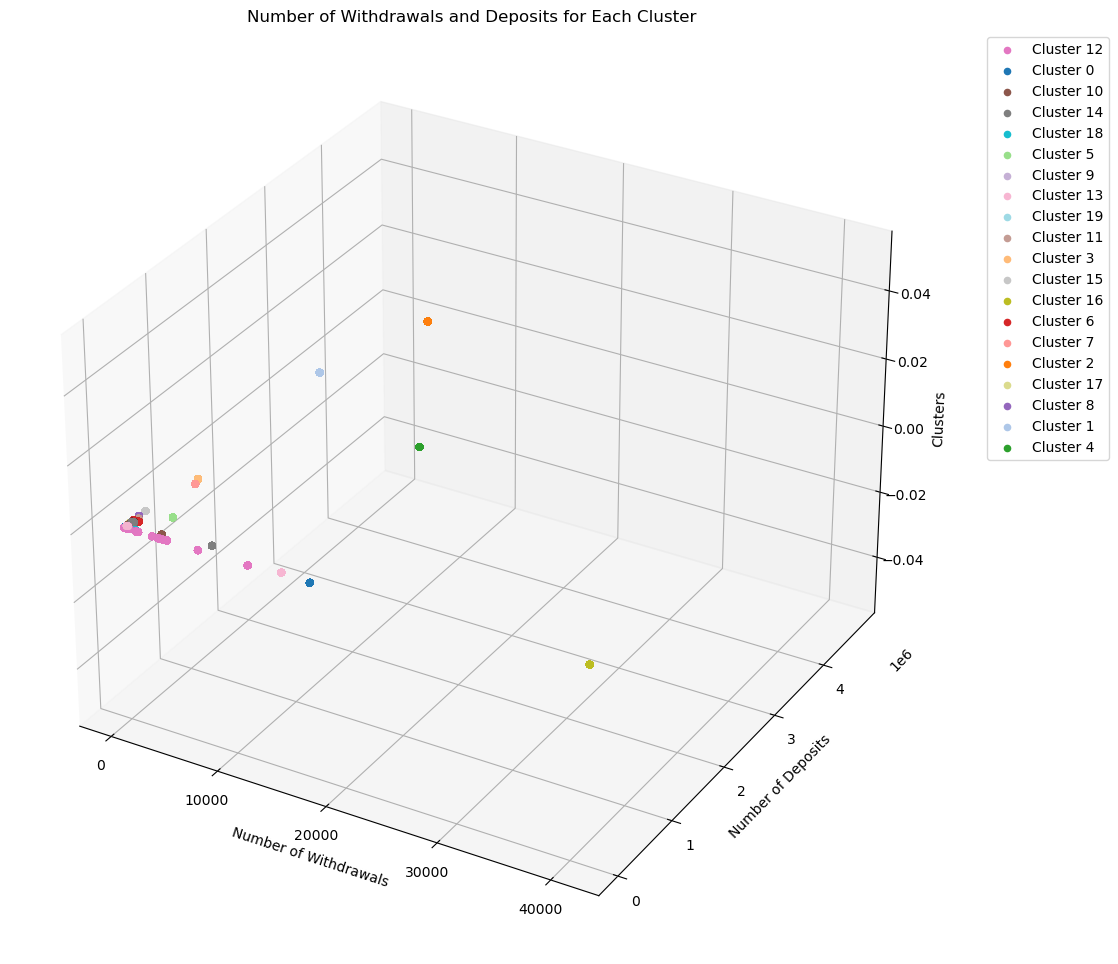

In [23]:
from sklearn.cluster import KMeans
from matplotlib.ticker import FuncFormatter

# Select only the relevant columns and drop missing values
df_reduced = data[['num_withdrawals_sum', 'num_deposits_sum']].dropna()

# Fit a KMeans model to the data
kmeans = KMeans(n_clusters=20)  # Choose a number of clusters that makes sense for your data
df_reduced['cluster'] = kmeans.fit_predict(df_reduced)

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection='3d')

# Create a colormap
colors = plt.get_cmap('tab20', lut=20)  # 'tab20' is a colormap with 20 distinct colors

# Plot each cluster
for cluster in df_reduced['cluster'].unique():
    cluster_data = df_reduced[df_reduced['cluster'] == cluster]
    ax.scatter(cluster_data['num_withdrawals_sum'], cluster_data['num_deposits_sum'], zs=0, zdir='z', s=20, 
               depthshade=True, label=f'Cluster {cluster}', color=colors(cluster))

# Format y-axis labels
formatter = FuncFormatter(lambda x, pos: '{:.0f}'.format(x))
ax.xaxis.set_major_formatter(formatter)
    
ax.set_xlabel('Number of Withdrawals')
ax.set_ylabel('Number of Deposits')
ax.set_zlabel('Clusters')
plt.title('Number of Withdrawals and Deposits for Each Cluster')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# These code belows are old df with only transaction, DO NOT RUN OTHERWISE LOSING CHART

In [3]:
# # Convert 'block_timestamp_frame' to datetime format
# data['block_timestamp_frame'] = pd.to_datetime(data['block_timestamp_frame'])

# # 1) Time of the day with most transactions
# data['hour'] = data['block_timestamp_frame'].dt.hour
# most_transactions_hour = data['hour'].mode()[0]

# # 2) Average gas fees for each tag
# average_gas_fees = data.groupby('encoded_label')['receipt_effective_gas_price_frame'].mean()


# print(f"Time of the day with most transactions: {most_transactions_hour}:00")
# print("\nAverage gas fees for each tag:")
# print(average_gas_fees)

Time of the day with most transactions: 8.0:00

Average gas fees for each tag:
encoded_label
0    1.486547e+10
1    5.018034e+10
Name: receipt_effective_gas_price_frame, dtype: float64


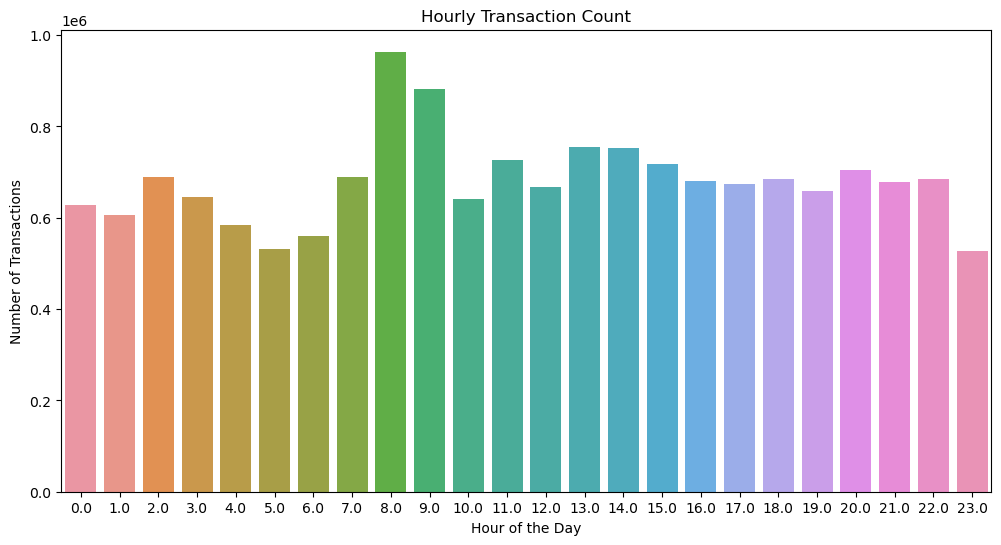

In [3]:
# # Convert 'block_timestamp_frame' to datetime format
# data['block_timestamp_frame'] = pd.to_datetime(data['block_timestamp_frame'])

# # Extract hour from 'block_timestamp_frame'
# data['hour'] = data['block_timestamp_frame'].dt.hour

# # Count transactions per hour
# hourly_transactions = data['hour'].value_counts().sort_index()

# # Plot the bar graph
# plt.figure(figsize=(12, 6))
# sns.barplot(x=hourly_transactions.index, y=hourly_transactions.values)
# plt.xlabel("Hour of the Day")
# plt.ylabel("Number of Transactions")
# plt.title("Hourly Transaction Count")
# plt.show()

In [4]:
# # Separate data by label
# data_0 = data[data['encoded_label'] == 0]
# data_1 = data[data['encoded_label'] == 1]

# # Count transactions per hour for each label
# hourly_transactions_0 = data_0['hour'].value_counts().sort_index()
# hourly_transactions_1 = data_1['hour'].value_counts().sort_index()

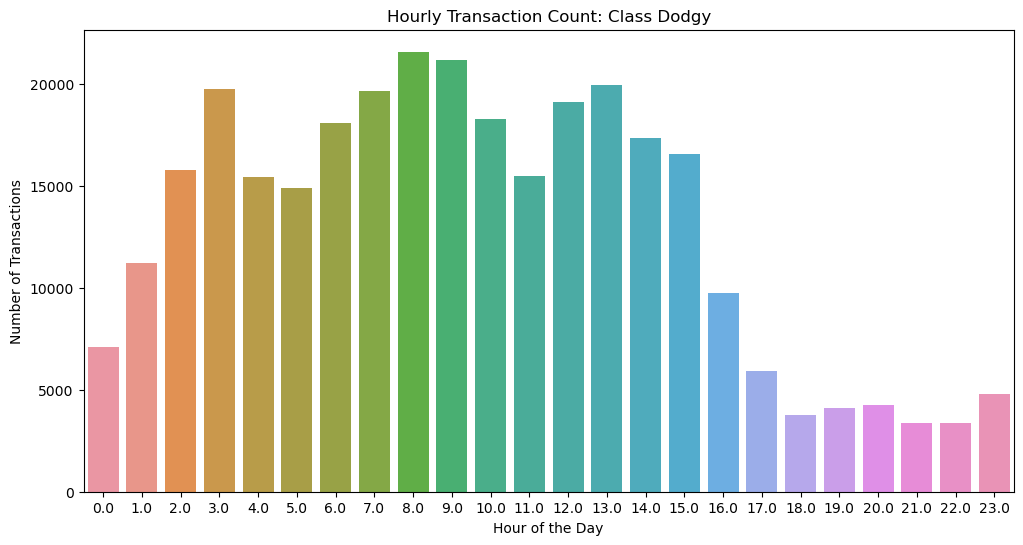

In [15]:
# # Plot the bar graph
# plt.figure(figsize=(12, 6))
# sns.barplot(x=hourly_transactions_0.index, y=hourly_transactions_0.values)
# plt.xlabel("Hour of the Day")
# plt.ylabel("Number of Transactions")
# plt.title("Hourly Transaction Count: Class Dodgy")
# plt.show()

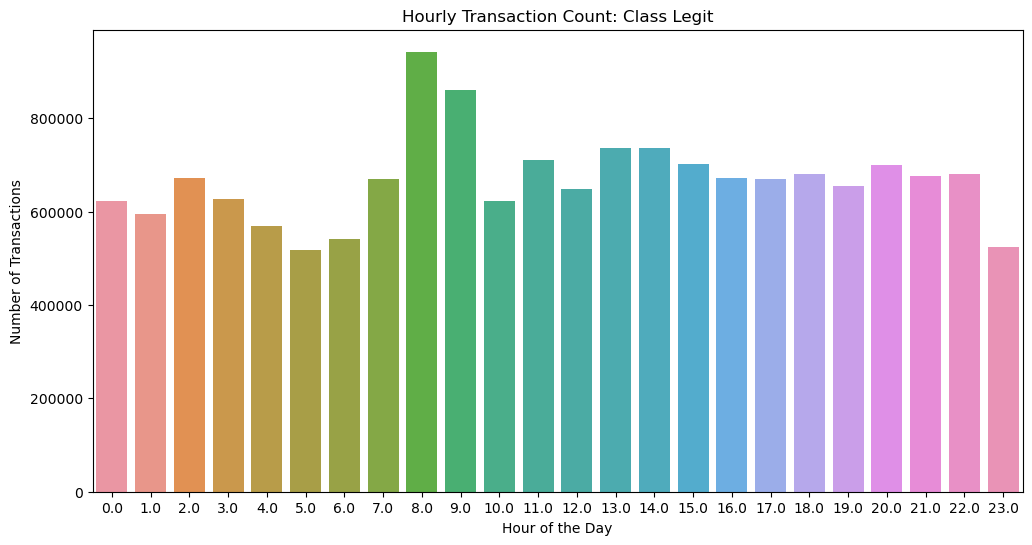

In [16]:
# # Plot the bar graph
# plt.figure(figsize=(12, 6))
# sns.barplot(x=hourly_transactions_1.index, y=hourly_transactions_1.values)
# plt.xlabel("Hour of the Day")
# plt.ylabel("Number of Transactions")
# plt.title("Hourly Transaction Count: Class Legit")
# plt.show()

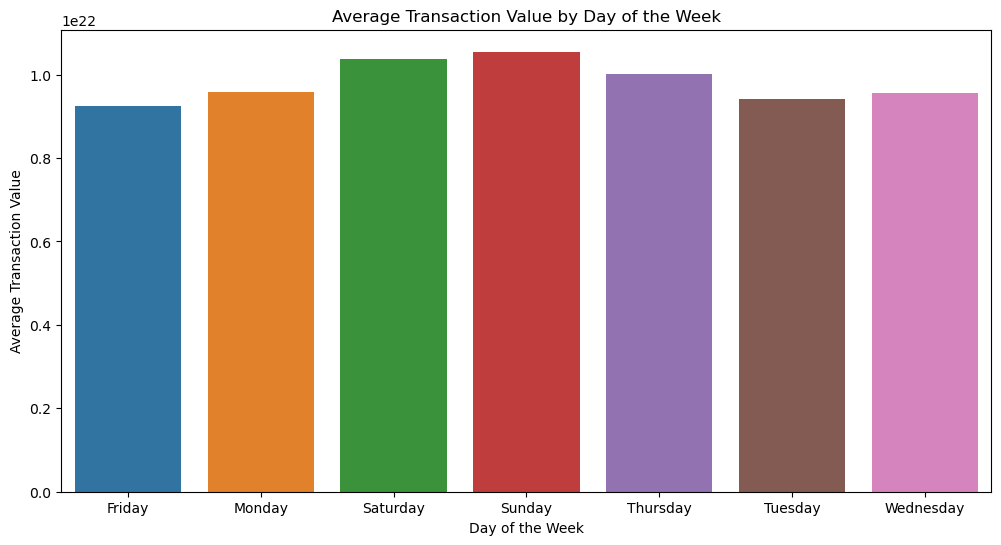

In [7]:
# # Convert 'eth_balance_frame' to float
# data['eth_balance_frame'] = data['eth_balance_frame'].astype(float)

# # Calculate the average transaction value by day of the week
# data['day_of_week'] = data['block_timestamp_frame'].dt.day_name()
# average_transaction_value_by_day = data.groupby('day_of_week')['eth_balance_frame'].mean()

# # Plot the bar graph
# plt.figure(figsize=(12, 6))
# sns.barplot(x=average_transaction_value_by_day.index, y=average_transaction_value_by_day.values)
# plt.xlabel("Day of the Week")
# plt.ylabel("Average Transaction Value")
# plt.title("Average Transaction Value by Day of the Week")
# plt.show()

In [8]:
# # Separate data by label
# data_0 = data[data['encoded_label'] == 0]
# data_1 = data[data['encoded_label'] == 1]

# # Count transactions per hour for each label
# # Calculate the average transaction value by day of the week
# average_transaction_value_by_day_0 = data_0.groupby('day_of_week')['eth_balance_frame'].mean()
# average_transaction_value_by_day_1 = data_1.groupby('day_of_week')['eth_balance_frame'].mean()

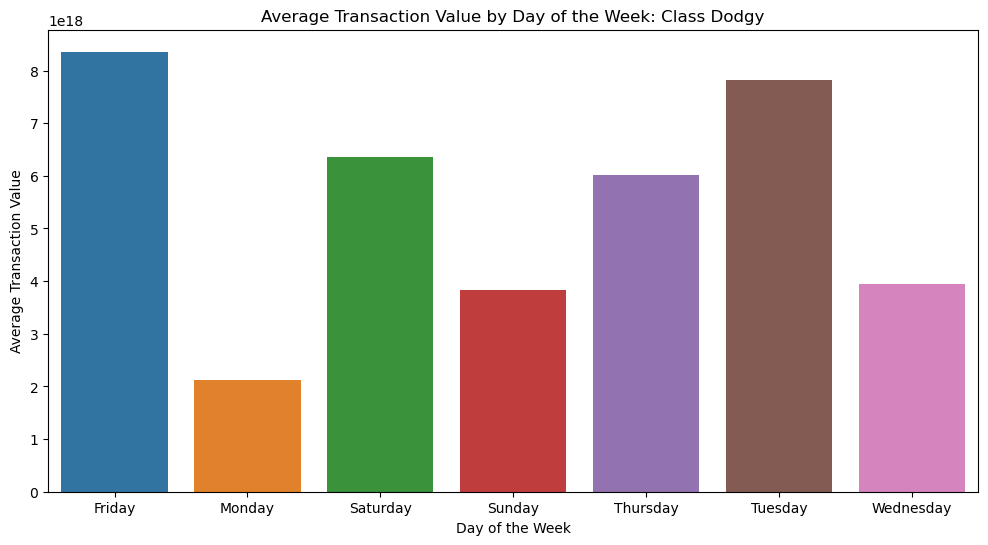

In [17]:
# # Plot the bar graph
# plt.figure(figsize=(12, 6))
# sns.barplot(x=average_transaction_value_by_day_0.index, y=average_transaction_value_by_day_0.values)
# plt.xlabel("Day of the Week")
# plt.ylabel("Average Transaction Value")
# plt.title("Average Transaction Value by Day of the Week: Class Dodgy")
# plt.show()

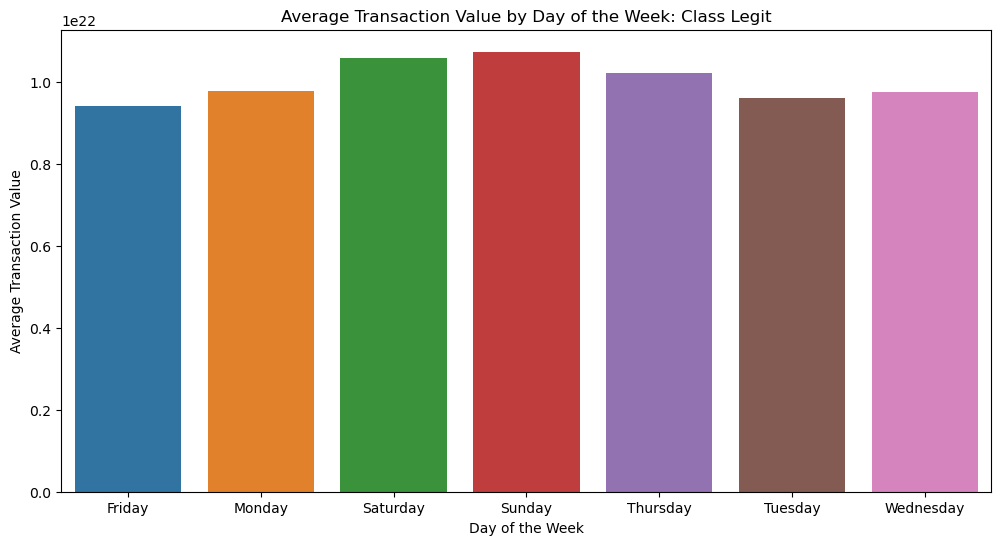

In [18]:
# # Plot the bar graph
# plt.figure(figsize=(12, 6))
# sns.barplot(x=average_transaction_value_by_day_1.index, y=average_transaction_value_by_day_1.values)
# plt.xlabel("Day of the Week")
# plt.ylabel("Average Transaction Value")
# plt.title("Average Transaction Value by Day of the Week: Class Legit")
# plt.show()

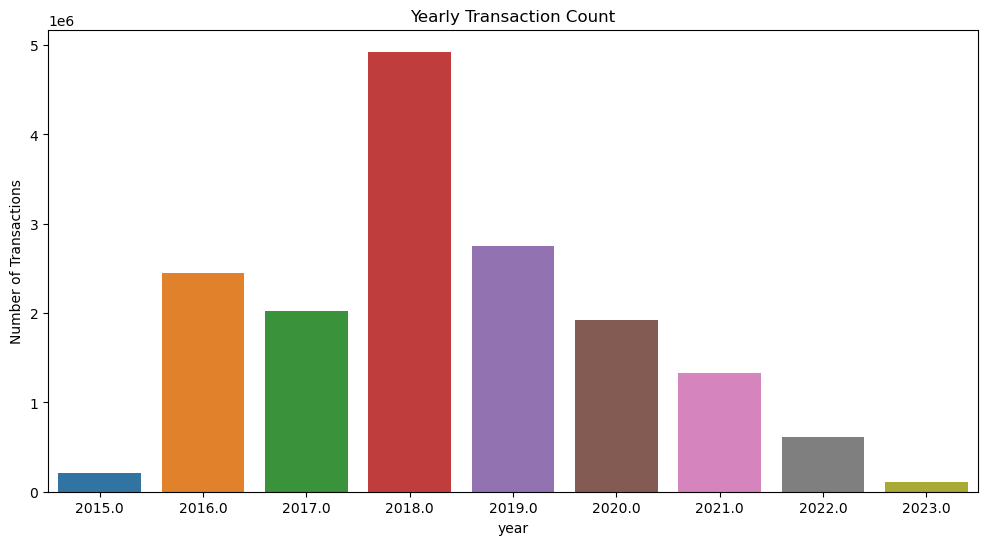

In [11]:
# # Extract hour from 'block_timestamp_frame'
# data['year'] = data['block_timestamp_frame'].dt.year

# # Count transactions per hour
# yearly_transactions = data['year'].value_counts().sort_index()

# # Plot the bar graph
# plt.figure(figsize=(12, 6))
# sns.barplot(x=yearly_transactions.index, y=yearly_transactions.values)
# plt.xlabel("year")
# plt.ylabel("Number of Transactions")
# plt.title("Yearly Transaction Count")
# plt.show()

In [12]:
# # Extract hour from 'block_timestamp_frame'
# data_0 = data[data['encoded_label'] == 0]
# data_1 = data[data['encoded_label'] == 1]

# # Count transactions per hour
# yearly_transactions_0 = data_0['year'].value_counts().sort_index()
# yearly_transactions_1 = data_1['year'].value_counts().sort_index()

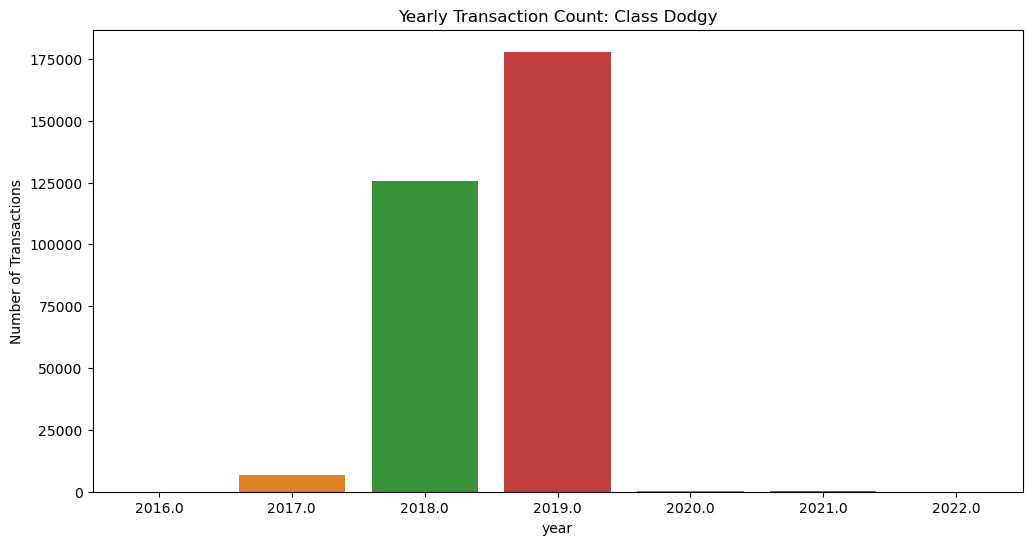

In [19]:
# # Plot the bar graph
# plt.figure(figsize=(12, 6))
# sns.barplot(x=yearly_transactions_0.index, y=yearly_transactions_0.values)
# plt.xlabel("year")
# plt.ylabel("Number of Transactions")
# plt.title("Yearly Transaction Count: Class Dodgy")
# plt.show()

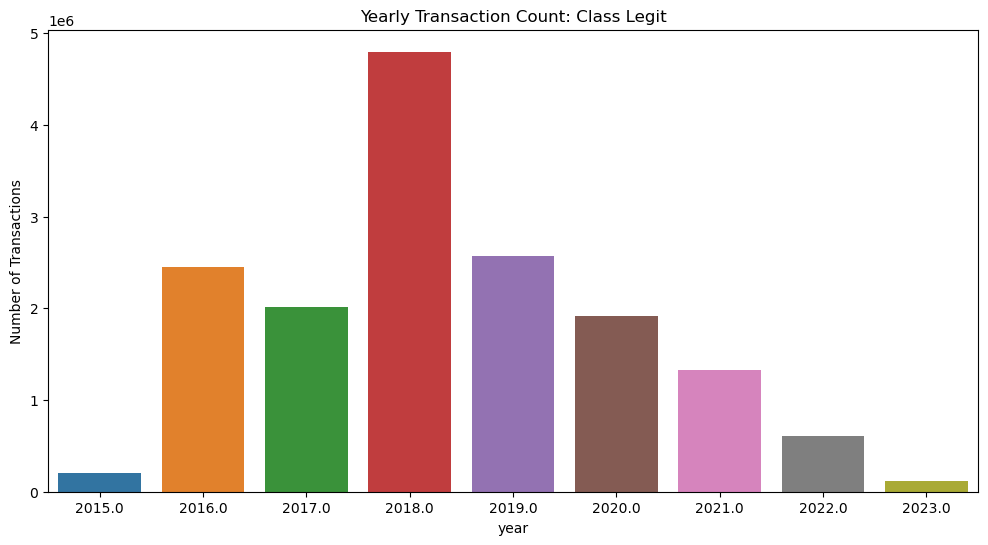

In [20]:
# # Plot the bar graph
# plt.figure(figsize=(12, 6))
# sns.barplot(x=yearly_transactions_1.index, y=yearly_transactions_1.values)
# plt.xlabel("year")
# plt.ylabel("Number of Transactions")
# plt.title("Yearly Transaction Count: Class Legit")
# plt.show()

C:\Users\vieth\AppData\Local\Temp\ipykernel_15616\3629503462.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_0['value_frame_bins'] = pd.qcut(data_0['value_frame'], q=50, duplicates='drop')
C:\Users\vieth\AppData\Local\Temp\ipykernel_15616\3629503462.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1['value_frame_bins'] = pd.qcut(data_1['value_frame'], q=50, duplicates='drop')


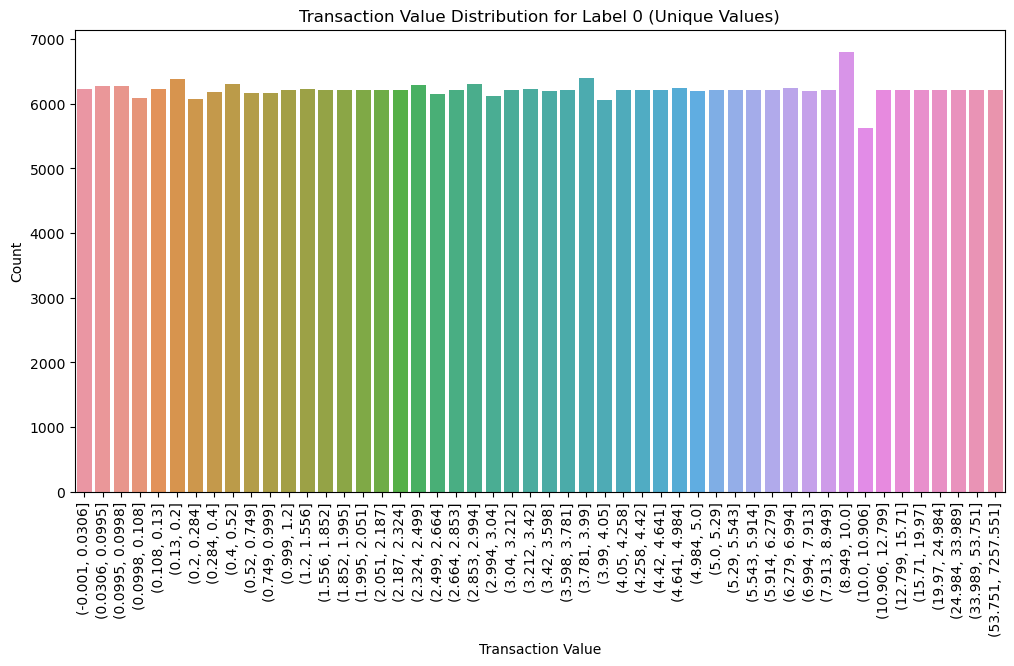

In [6]:
# # Convert 'value_frame' to float
# data['value_frame'] = data['value_frame'].astype(float)
# # Convert from wei to ETH
# data['value_frame'] = data['value_frame'] / 1e18
# data['eth_balance_frame'] = data['eth_balance_frame'] / 1e18


# # Separate data by label
# data_0 = data[data['encoded_label'] == 0]
# data_1 = data[data['encoded_label'] == 1]

# # Create bins for 'value_frame' column
# data_0['value_frame_bins'] = pd.qcut(data_0['value_frame'], q=50, duplicates='drop')
# data_1['value_frame_bins'] = pd.qcut(data_1['value_frame'], q=50, duplicates='drop')

# # # Remove duplicates from 'value_frame_bins' for each label
# # unique_data_0 = data_0.drop_duplicates(subset=['value_frame_bins'])
# # unique_data_1 = data_1.drop_duplicates(subset=['value_frame_bins'])

# # Plot the histogram for label 0
# plt.figure(figsize=(12, 6))
# sns.countplot(data=data_0, x='value_frame_bins')
# plt.xlabel("Transaction Value")
# plt.ylabel("Count")
# plt.title("Transaction Value Distribution for Label 0 (Unique Values)")
# plt.xticks(rotation=90)  # To make x-axis labels readable
# plt.show()

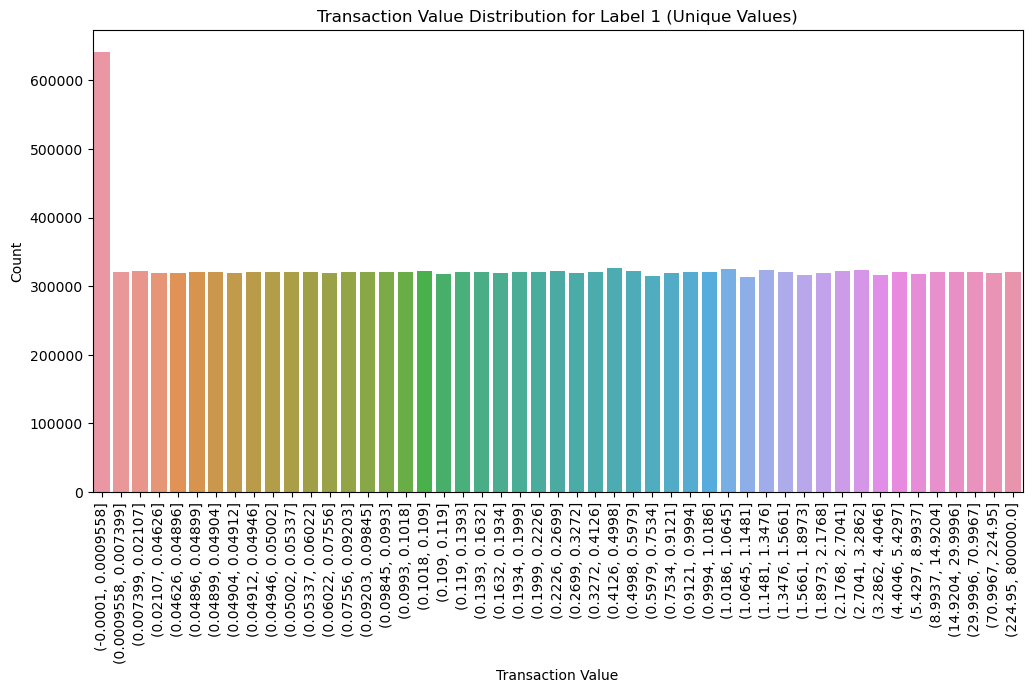

In [7]:
# # Plot the histogram for label 1
# plt.figure(figsize=(12, 6))
# sns.countplot(data=data_1, x='value_frame_bins')
# plt.xlabel("Transaction Value")
# plt.ylabel("Count")
# plt.title("Transaction Value Distribution for Label 1 (Unique Values)")
# plt.xticks(rotation=90)  # To make x-axis labels readable
# plt.show()

# Scale it

** to_csv with scaled data takes massive time: ~30-40mins.

In [3]:
from datetime import datetime

processed_data = pd.read_csv('./output/50_50_balanced_data.csv')

# split the string column into separate features
def split_string(text):
    features = text.split(',')
    for i in range(len(features)):
        if i == 0 or i == 1:
            if features[i] != 'nan':
                timestamp = datetime.strptime(features[i], '%Y-%m-%d %H:%M:%S%z')
                features[i] = timestamp.timestamp()
            else:
                features[i] = datetime(2000, 1, 1, 0, 0, 0, tzinfo=None).timestamp()
        else:
            features[i] = float(features[i])
    return features 

features = processed_data['text'].apply(split_string)
features

0           [1440682453.0, 1682874899.0, 2593421.0, 9.6536...
1           [1504794780.0, 1663197252.0, 3343085.0, 9.8841...
2           [1527327833.0, 1581524444.0, 61021.0, 0.0, 1.6...
3           [1527245330.0, 1572504223.0, 241212.0, 1.24271...
4           [1527245330.0, 1572504223.0, 241212.0, 1.24271...
                                  ...                        
16333467    [1539523956.0, 1549720125.0, 616.0, 3567241665...
16333468    [1463196785.0, 1547486815.0, 123580.0, 1209202...
16333469    [1527245330.0, 1572504223.0, 241212.0, 1.24271...
16333470    [1504794780.0, 1663197252.0, 3343085.0, 9.8841...
16333471    [1440682453.0, 1682874899.0, 2593421.0, 9.6536...
Name: text, Length: 16333472, dtype: object

Detecting some rows have nan value due to oversampling and undersampling.

In [4]:
processed_data['text'] = features
processed_data

,text,encoded_label
0,"[1440682453.0, 1682874899.0, 2593421.0, 9.6536...",1
1,"[1504794780.0, 1663197252.0, 3343085.0, 9.8841...",1
2,"[1527327833.0, 1581524444.0, 61021.0, 0.0, 1.6...",1
3,"[1527245330.0, 1572504223.0, 241212.0, 1.24271...",0
4,"[1527245330.0, 1572504223.0, 241212.0, 1.24271...",0
...,...,...
16333467,"[1539523956.0, 1549720125.0, 616.0, 3567241665...",0
16333468,"[1463196785.0, 1547486815.0, 123580.0, 1209202...",1
16333469,"[1527245330.0, 1572504223.0, 241212.0, 1.24271...",0
16333470,"[1504794780.0, 1663197252.0, 3343085.0, 9.8841...",1


In [5]:
# Check for NaN and infinite values
if processed_data.isnull().values.any():
    print("There are NaN values in the processed_data dataframe")
    
# Convert it to float32 for Random Forest library
from sklearn.preprocessing import MinMaxScaler

# Convert the "text" column to a numpy array
text_array = np.array(list(processed_data["text"]))

# Scale down the values in the array to the range [0, 1]
scaler = MinMaxScaler()
text_array_scaled = scaler.fit_transform(text_array)

# Cast the scaled array to the float32 data type
text_array_scaled = text_array_scaled.astype(np.float32)

# Create a new dataframe with the scaled "text" column and the original "encoded_label" column
new_df = pd.DataFrame({'text': list(text_array_scaled), 'encoded_label': processed_data['encoded_label']})

# Replace the original "processed_data" dataframe with the new dataframe
processed_data = new_df

In [6]:
processed_data

,text,encoded_label
0,"[0.0071405405, 0.9996219, 0.54753876, 0.002658...",1
1,"[0.2726931, 0.91283846, 0.7058124, 0.002722036...",1
2,"[0.36602476, 0.55264056, 0.012882917, 0.0, 0.0...",1
3,"[0.36568302, 0.51285905, 0.050925948, 3.422385...",0
4,"[0.36568302, 0.51285905, 0.050925948, 3.422385...",0
...,...,...
16333467,"[0.41654095, 0.41237536, 0.00012984258, 9.8240...",0
16333468,"[0.10039466, 0.4025259, 0.026090756, 3.3300845...",1
16333469,"[0.36568302, 0.51285905, 0.050925948, 3.422385...",0
16333470,"[0.2726931, 0.91283846, 0.7058124, 0.002722036...",1


In [8]:
# Check for NaN and infinite values   
print ('0' if np.isnan(processed_data["text"][16333468]).any() else '1')
mask = processed_data['text'].apply(lambda x: np.isnan(np.sum(x)))
new_processed_data = processed_data[~mask]
new_processed_data

1


,text,encoded_label
0,"[0.0071405405, 0.9996219, 0.54753876, 0.002658...",1
1,"[0.2726931, 0.91283846, 0.7058124, 0.002722036...",1
2,"[0.36602476, 0.55264056, 0.012882917, 0.0, 0.0...",1
3,"[0.36568302, 0.51285905, 0.050925948, 3.422385...",0
4,"[0.36568302, 0.51285905, 0.050925948, 3.422385...",0
...,...,...
16333467,"[0.41654095, 0.41237536, 0.00012984258, 9.8240...",0
16333468,"[0.10039466, 0.4025259, 0.026090756, 3.3300845...",1
16333469,"[0.36568302, 0.51285905, 0.050925948, 3.422385...",0
16333470,"[0.2726931, 0.91283846, 0.7058124, 0.002722036...",1


In [9]:
print ("Data label distribution check")
labels_dict = dict()
for row in tqdm(new_processed_data.iterrows()):
#     print (row[1]['Label'])
    label_val = row[1]['encoded_label']
    if label_val not in labels_dict.keys():
        labels_dict[label_val] = 1
    else:
        labels_dict[label_val] += 1
        
print (labels_dict)

Data label distribution check


16333472it [06:34, 41366.86it/s]

{1: 8166736, 0: 8166736}


In [10]:
new_processed_data.to_csv("./output/non_nan_balanced_data.csv", index=False)